# GAN

## Import libraries


In [1]:
%matplotlib inline

from __future__ import print_function
from PIL import Image
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchsummary
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from google.colab import files
from IPython.display import HTML
import time
import shutil
import cv2
import json
import argparse
import os
import numpy as np
import math
import sys
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F
import torch.autograd as autograd
from torch import squeeze
from torch import Tensor
from IPython.display import clear_output

manualSeed = 999

random.seed(manualSeed)
torch.manual_seed(manualSeed)

## Connect to Google Drive

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


## Load data

In [3]:
!cp /content/MyDrive/MyDrive/0-MasterThesis/GAN-TESTS/Haak_flight1.zip /content
!unzip /content/Haak_flight1.zip

!mkdir /content/True
!mv /content/norm_1100_3900_true /content/True/

!mkdir /content/Ano_land
!mv /content/norm_1100_3900_ano_land /content/Ano_land/

!mkdir /content/Ano_object
!mv /content/norm_1100_3900_ano_object /content/Ano_object/

# Root directory for dataset
dataroot = "/content/True"

%cd /content/True/
%rm -r .ipynb_checkpoints
%cd /content/
clear_output(wait=True)

Streaming output truncated to the last 5000 lines.
  inflating: norm_1100_3900_true/14785.png  
  inflating: norm_1100_3900_true/14786.png  
  inflating: norm_1100_3900_true/14787.png  
  inflating: norm_1100_3900_true/14788.png  
  inflating: norm_1100_3900_true/14789.png  
  inflating: norm_1100_3900_true/14790.png  
  inflating: norm_1100_3900_true/14791.png  
  inflating: norm_1100_3900_true/14792.png  
  inflating: norm_1100_3900_true/14793.png  
  inflating: norm_1100_3900_true/14794.png  
  inflating: norm_1100_3900_true/14795.png  
  inflating: norm_1100_3900_true/14796.png  
  inflating: norm_1100_3900_true/14797.png  
  inflating: norm_1100_3900_true/14798.png  
  inflating: norm_1100_3900_true/14799.png  
  inflating: norm_1100_3900_true/14800.png  
  inflating: norm_1100_3900_true/14801.png  
  inflating: norm_1100_3900_true/14802.png  
  inflating: norm_1100_3900_true/14803.png  
  inflating: norm_1100_3900_true/14804.png  
  inflating: norm_1100_3900_true/14805.png  
  in

# Aumentation Visualization

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                              
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomVerticalFlip(p=0.5),
                               transforms.GaussianBlur(kernel_size=(1, 3), sigma=(0.1, 3)),
                               transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),

                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5], std=[0.5]),
                           ]))

In [24]:
true = Image.open(os.path.join('/content/True/norm_1100_3900_true/', '05337.png'))
anom = Image.open(os.path.join('/content/Ano_object/norm_1100_3900_ano_object/', '05345.png'))

In [77]:
t = transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(256),
                               transforms.CenterCrop(256),
                        
                               transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])
                           ])

aug = transforms.Compose([
                              transforms.ColorJitter( hue=0.5),
                           ])

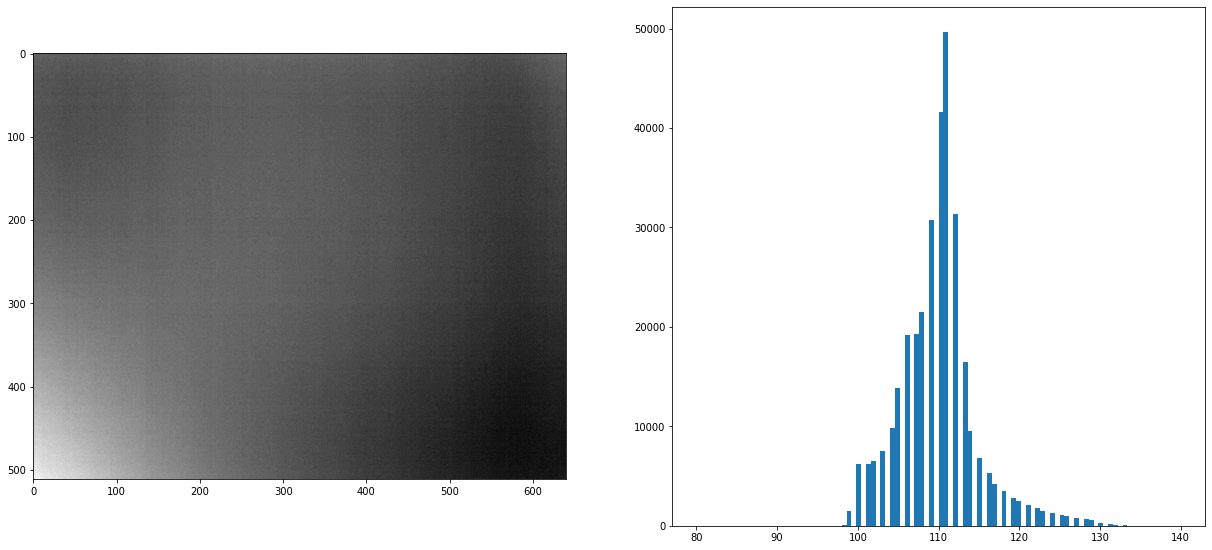

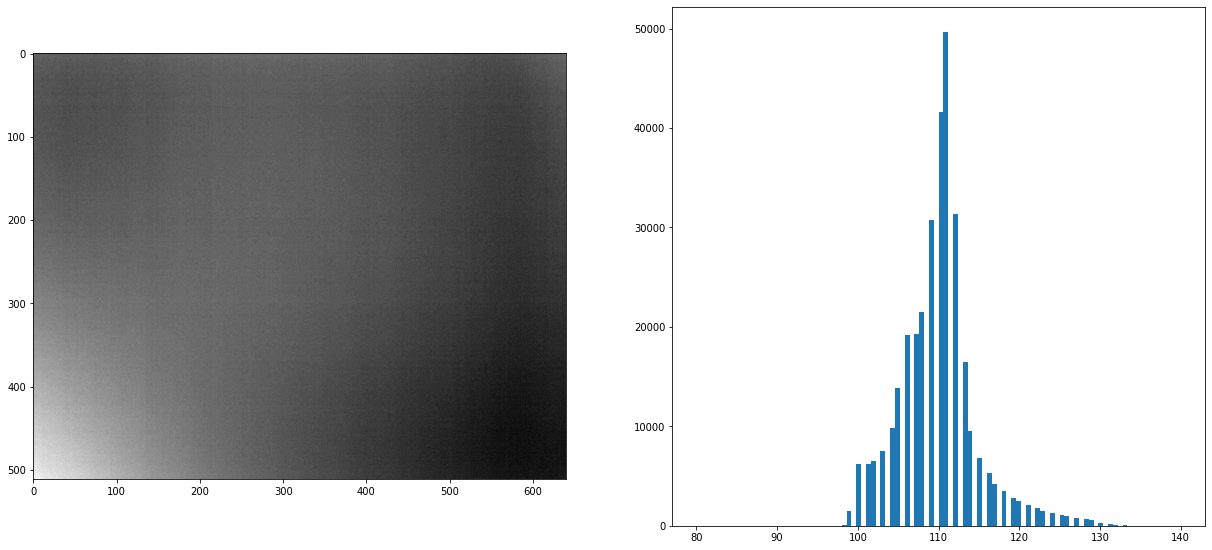

Max true: 135
Max anom: 176
Min true: 97
Min anom: 79
Range true: 38
Range anom: 97
Mean true: 109.86992492675782
Mean anom: 110.02713928222656


In [79]:
max_ = np.max(true)
min_ = np.min(true)

plt.figure(figsize=(21,21))
plt.subplot(2,2,1)
plt.imshow(true, cmap='gray', vmin=min_, vmax=max_)
plt.subplot(2,2,2)
plt.hist(np.array(true).flatten(), bins=100, range=(80,140))

img_aug = aug(true)

plt.figure(figsize=(21,21))
plt.subplot(2,2,1)
plt.imshow(img_aug, cmap='gray', vmin=min_, vmax=max_)
plt.subplot(2,2,2)
plt.hist(np.array(img_aug).flatten(), bins=100, range=(80,140))

plt.show()


print('Max true: {}'.format(np.max(np.array(true))))
print('Max anom: {}'.format(np.max(np.array(anom))))
print('Min true: {}'.format(np.min(np.array(true))))
print('Min anom: {}'.format(np.min(np.array(anom))))
print('Range true: {}'.format(np.max(np.array(true))-np.min(np.array(true))))
print('Range anom: {}'.format(np.max(np.array(anom))-np.min(np.array(anom))))
print('Mean true: {}'.format(np.mean(np.array(true))))
print('Mean anom: {}'.format(np.mean(np.array(anom))))

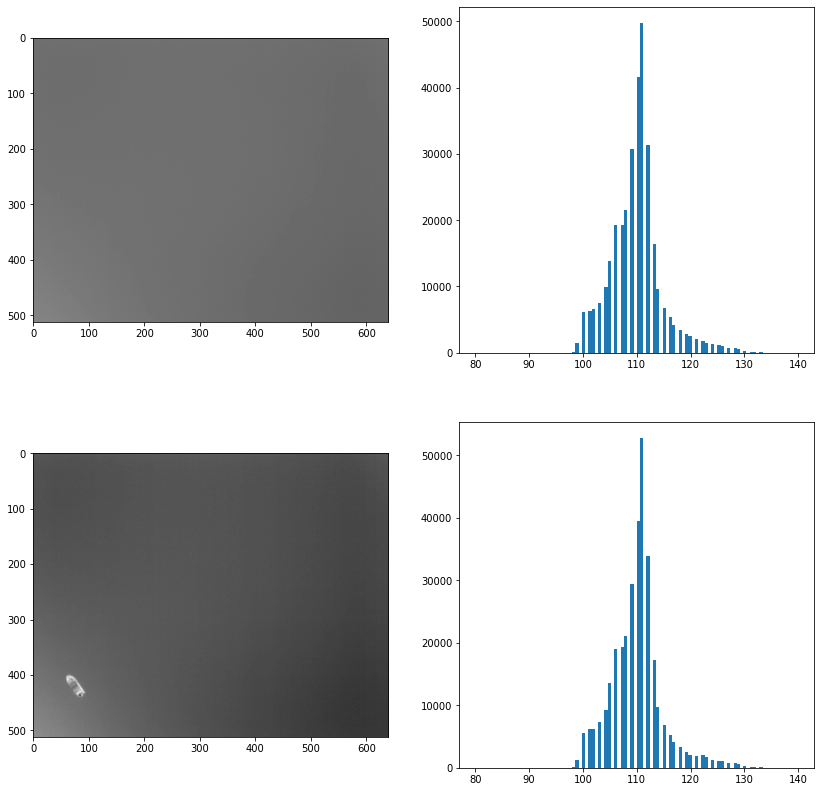

Max true: 135
Max anom: 176
Min true: 97
Min anom: 79
Range true: 38
Range anom: 97
Mean true: 109.86992492675782
Mean anom: 110.02713928222656


In [49]:

plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
plt.imshow(true, cmap='gray', vmin=0, vmax=255)
plt.subplot(2,2,2)
plt.hist(np.array(true).flatten(), bins=100, range=(80,140))

plt.subplot(2,2,3)
plt.imshow(anom, cmap='gray')
plt.subplot(2,2,4)
plt.hist(np.array(anom).flatten(), bins=100, range=(80,140))

plt.show()


print('Max true: {}'.format(np.max(np.array(true))))
print('Max anom: {}'.format(np.max(np.array(anom))))
print('Min true: {}'.format(np.min(np.array(true))))
print('Min anom: {}'.format(np.min(np.array(anom))))
print('Range true: {}'.format(np.max(np.array(true))-np.min(np.array(true))))
print('Range anom: {}'.format(np.max(np.array(anom))-np.min(np.array(anom))))
print('Mean true: {}'.format(np.mean(np.array(true))))
print('Mean anom: {}'.format(np.mean(np.array(anom))))

## Div Data Analysis

In [4]:
true = Image.open(os.path.join('/content/True/norm_1100_3900_true/', '05337.png'))
anom = Image.open(os.path.join('/content/Ano_object/norm_1100_3900_ano_object/', '05345.png'))

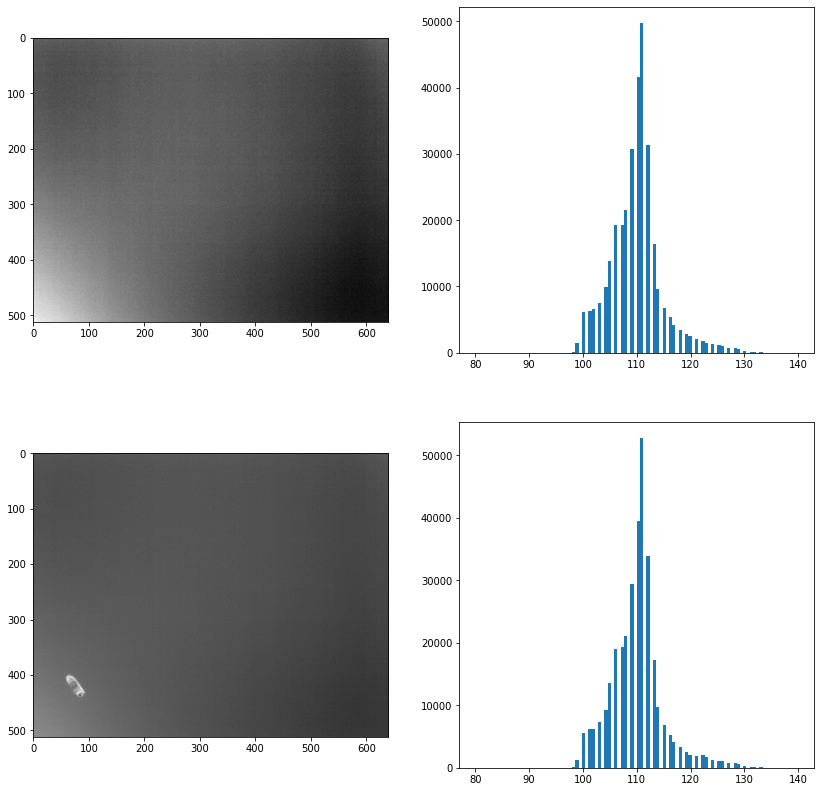

Max true: 135
Max anom: 176
Min true: 97
Min anom: 79
Range true: 38
Range anom: 97
Mean true: 109.86992492675782
Mean anom: 110.02713928222656


In [5]:
plt.figure(figsize=(14,14))

plt.subplot(2,2,1)
plt.imshow(true, cmap='gray')
plt.subplot(2,2,2)
plt.hist(np.array(true).flatten(), bins=100, range=(80,140))

plt.subplot(2,2,3)
plt.imshow(anom, cmap='gray')
plt.subplot(2,2,4)
plt.hist(np.array(anom).flatten(), bins=100, range=(80,140))

plt.show()


print('Max true: {}'.format(np.max(np.array(true))))
print('Max anom: {}'.format(np.max(np.array(anom))))


print('Min true: {}'.format(np.min(np.array(true))))
print('Min anom: {}'.format(np.min(np.array(anom))))

print('Range true: {}'.format(np.max(np.array(true))-np.min(np.array(true))))
print('Range anom: {}'.format(np.max(np.array(anom))-np.min(np.array(anom))))


print('Mean true: {}'.format(np.mean(np.array(true))))
print('Mean anom: {}'.format(np.mean(np.array(anom))))

In [6]:
t = transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(256),
                               transforms.CenterCrop(256),
                        
                               transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5])
                           ])

a = transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(256),
                               transforms.CenterCrop(256),
                        
                               transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5])
                           ])



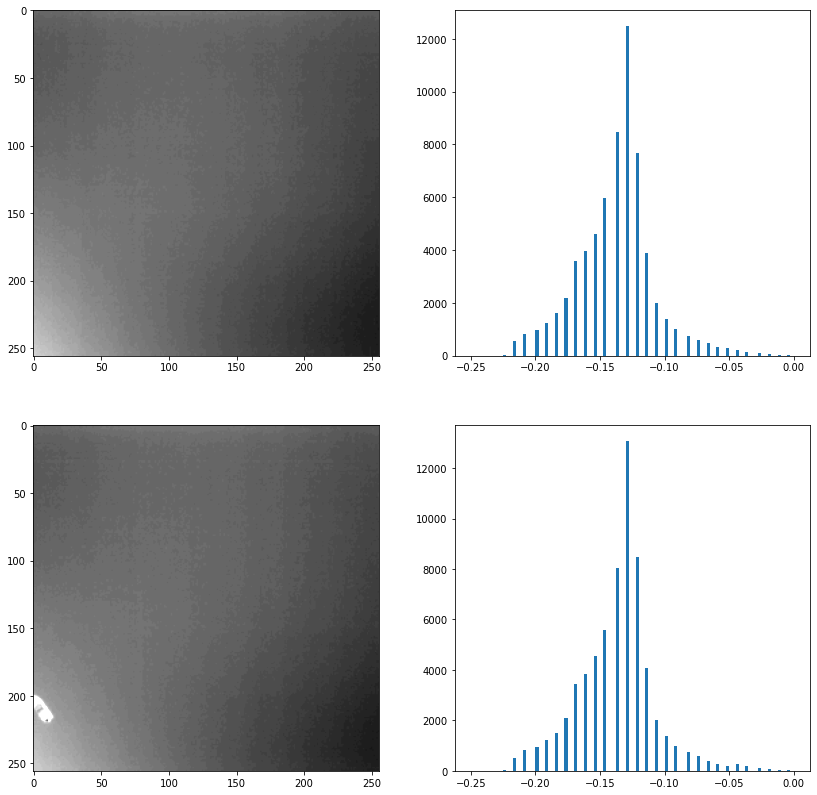

Max true: -0.00
Max anom: 0.30
Min true: -0.22
Min anom: -0.22
Range true: 0.22
Range anom: 0.53
Mean true: -0.14
Mean anom: -0.14


In [7]:
'''
plt.figure(figsize=(14,14))

plt.subplot(2,2,1)
plt.imshow(t(true)[0], cmap='gray', vmin=0.375, vmax=0.5)
plt.subplot(2,2,2)
plt.hist(np.array(t(true)[0]).flatten(), bins=100, range=(0.3,0.5))

plt.subplot(2,2,3)
plt.imshow(a(anom)[0], cmap='gray', vmin=0.375, vmax=0.5)
plt.subplot(2,2,4)
plt.hist(np.array(a(anom)[0]).flatten(), bins=100, range=(0.3,0.5))

plt.show()

plt.figure(figsize=(14,14))

plt.subplot(2,2,1)
plt.imshow(t(true), cmap='gray')
plt.subplot(2,2,2)
plt.hist(np.array(t(true)).flatten(), bins=100, range=(80,140))

plt.subplot(2,2,3)
plt.imshow(t(anom), cmap='gray')
plt.subplot(2,2,4)
plt.hist(np.array(t(anom)).flatten(), bins=100, range=(80,140))

plt.show()
'''

plt.figure(figsize=(14,14))

plt.subplot(2,2,1)
plt.imshow(t(true)[0], cmap='gray', vmin=-0.25, vmax=0.05)
plt.subplot(2,2,2)
plt.hist(np.array(t(true)[0]).flatten(), bins=100, range=(-0.25,0))

plt.subplot(2,2,3)
plt.imshow(a(anom)[0], cmap='gray', vmin=-0.25, vmax=0.05)
plt.subplot(2,2,4)
plt.hist(np.array(a(anom)[0]).flatten(), bins=100, range=(-0.25,0))

plt.show()


print('Max true: {:.2f}'.format(np.max(np.array(t(true)))))
print('Max anom: {:.2f}'.format(np.max(np.array(a(anom)))))


print('Min true: {:.2f}'.format(np.min(np.array(t(true)))))
print('Min anom: {:.2f}'.format(np.min(np.array(a(anom)))))

print('Range true: {:.2f}'.format(np.max(np.array(t(true)))-np.min(np.array(t(true)))))
print('Range anom: {:.2f}'.format(np.max(np.array(a(anom)))-np.min(np.array(a(anom)))))

print('Mean true: {:.2f}'.format(np.mean(np.array(t(true)))))
print('Mean anom: {:.2f}'.format(np.mean(np.array(a(anom)))))

## Dataloader
------

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed.
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [8]:
workers = 2
batch_size = 128
image_size = 512
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

# For new model setup
os.makedirs("images", exist_ok=True)

n_epochs = 200
#batch_size=100
lr=0.0002
b1=0.5
b2=0.999
n_cpu=8
latent_dim=100
img_size=image_size
channels=1
n_critic=5 # help="number of training steps for discriminator per iter")
clip_value=0.01 # help="lower and upper clip value for disc. weights")
sample_interval=400 # help="interval betwen image samples")

img_shape = (channels, img_size, img_size)

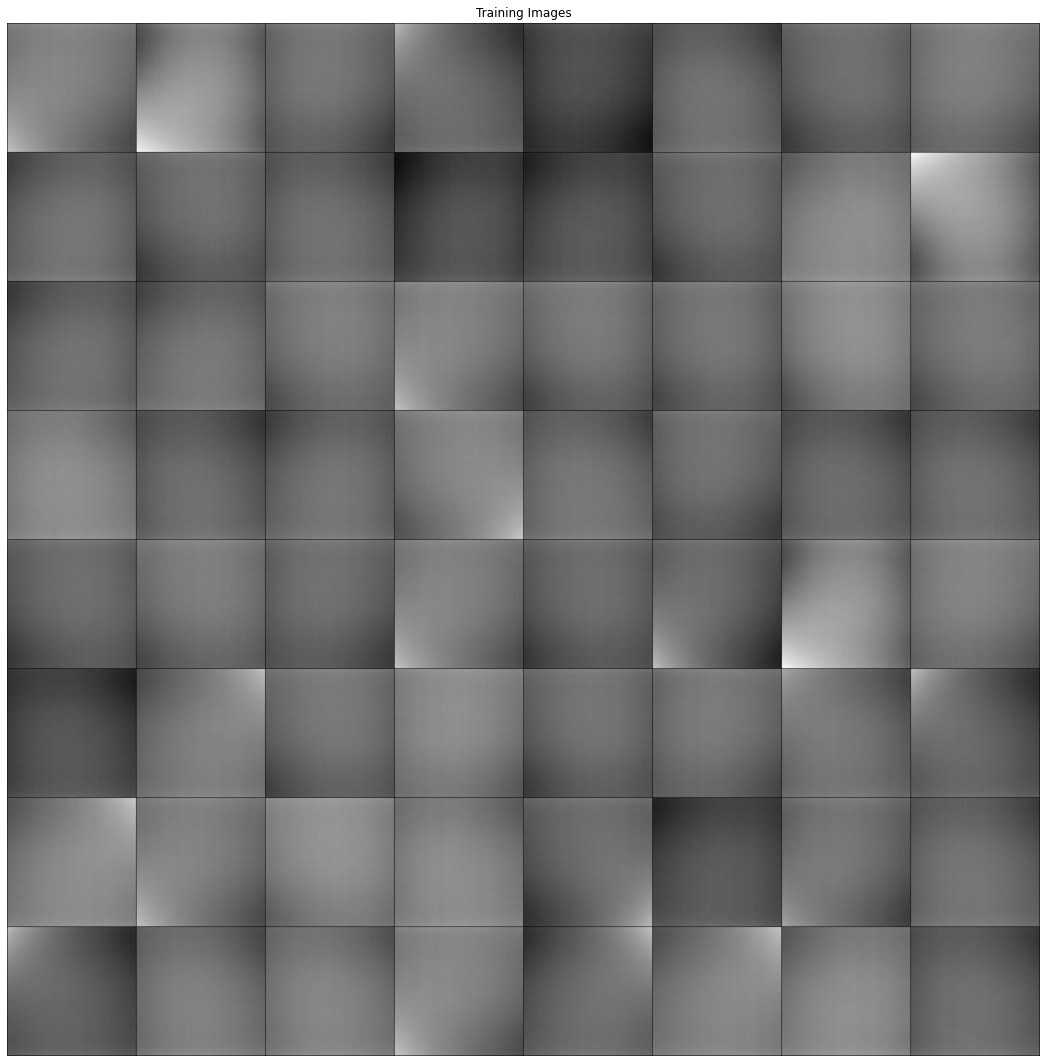

In [9]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

#dataset = dset.ImageFolder(root=dataroot,
#                           transform=transforms.Compose([
#                               transforms.Resize(image_size),
#                               transforms.CenterCrop(image_size),
#                               transforms.ToTensor(),
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                           ]))

# EGET SETT - NORMALIZE

# transforms.ConvertImageDtype(torch.uint8),

torch.manual_seed(69)

'''
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5], std=[0.5]),
                           ]))


dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5], std=[0.5]),
                           ]))
'''
### Augmentation
mean = 109.69
std  = 2.636

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                              
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomVerticalFlip(p=0.5),

                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5], std=[0.5]),
                           ]))


'''
# MNIST
dataset = dset.MNIST('/content/', download=True, train=True,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5], std=[0.5]),
                           ]))
dataset = dset.MNIST('/content/', download=True, train=True,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                           ]))
'''
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(19, 19))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
torch.mean(real_batch[0].to(device)[0:64].cpu())

tensor(-0.1375)

In [11]:
torch.std(real_batch[0].to(device)[0:64].cpu())

tensor(0.0346)

In [12]:
real_batch[0].to(device)[0].cpu().mean()

tensor(-0.1143)

## Initialize weights and biases


In [13]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator


### Generator: 64x64 Original


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

### Generator: 64x64 DCGAN


In [ ]:
# Generator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
nc = 1
image_size = 64

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            #nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            ## nn.Dropout(p=0.2),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            ## nn.Dropout(p=0.2),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            ## nn.Dropout(p=0.2),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        img = self.main(input)
        img = img.view(img.shape[0], *img_shape)
        return img

# Create the generator
generator = Generator(ngpu).to(device)


# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
generator.apply(weights_init)

torchsummary.summary(generator,input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
              ReLU-2            [-1, 512, 4, 4]               0
   ConvTranspose2d-3            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-4            [-1, 256, 8, 8]             512
              ReLU-5            [-1, 256, 8, 8]               0
   ConvTranspose2d-6          [-1, 128, 16, 16]         524,288
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
   ConvTranspose2d-9           [-1, 64, 32, 32]         131,072
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
  ConvTranspose2d-12            [-1, 1, 64, 64]           1,024
             Tanh-13            [-1, 1, 64, 64]               0
Total params: 3,573,632
Trainable param

### Generator: 64x64 DCGAN - resize-convolution


In [ ]:
# Generator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
nc = 1
image_size = 64

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.ReLU(True),

            # state size. (ngf*8) x 4 x 4
            #nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.Upsample(scale_factor = 2, mode='bilinear', align_corners=False),
            nn.ReflectionPad2d(1),
            nn.Conv2d(ngf * 8, ngf * 4, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            ## nn.Dropout(p=0.2),

            # state size. (ngf*4) x 8 x 8
            #nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.Upsample(scale_factor = 2, mode='bilinear', align_corners=False),
            nn.ReflectionPad2d(1),
            nn.Conv2d(ngf * 4, ngf * 2, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            ## nn.Dropout(p=0.2),

            # state size. (ngf*2) x 16 x 16
            #nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.Upsample(scale_factor = 2, mode='bilinear', align_corners=False),
            nn.ReflectionPad2d(1),
            nn.Conv2d( ngf * 2, ngf, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            ## nn.Dropout(p=0.2),

            # state size. (ngf) x 32 x 32
            #nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Upsample(scale_factor = 2, mode='bilinear', align_corners=False),
            nn.ReflectionPad2d(1),
            nn.Conv2d(ngf, nc, kernel_size=3, stride=1, padding=0),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        img = self.main(input)
        img = img.view(img.shape[0], *img_shape)
        return img

# Create the generator
generator = Generator(ngpu).to(device)


# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
generator.apply(weights_init)

torchsummary.summary(generator,input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
              ReLU-2            [-1, 512, 4, 4]               0
          Upsample-3            [-1, 512, 8, 8]               0
   ReflectionPad2d-4          [-1, 512, 10, 10]               0
            Conv2d-5            [-1, 256, 8, 8]       1,179,904
       BatchNorm2d-6            [-1, 256, 8, 8]             512
              ReLU-7            [-1, 256, 8, 8]               0
          Upsample-8          [-1, 256, 16, 16]               0
   ReflectionPad2d-9          [-1, 256, 18, 18]               0
           Conv2d-10          [-1, 128, 16, 16]         295,040
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
         Upsample-13          [-1, 128, 32, 32]               0
  ReflectionPad2d-14          [-1, 128,

### Generator: 64x64 DCGAN - resize-convolution - smaller


In [ ]:
# Generator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
nc = 1
image_size = 64

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            #nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.Upsample(scale_factor = 2, mode='bilinear', align_corners=False),
            nn.ReflectionPad2d(1),
            nn.Conv2d(ngf * 4, ngf * 2, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            ## nn.Dropout(p=0.2),

            # state size. (ngf*2) x 16 x 16
            #nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.Upsample(scale_factor = 4, mode='bilinear', align_corners=False),
            nn.ReflectionPad2d(1),
            nn.Conv2d( ngf * 2, ngf, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            ## nn.Dropout(p=0.2),

            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        img = self.main(input)
        #img = img.view(img.shape[0], *img_shape)
        return img

# Create the generator
generator = Generator(ngpu).to(device)


# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
generator.apply(weights_init)

torchsummary.summary(generator,input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
              ReLU-2            [-1, 256, 4, 4]               0
          Upsample-3            [-1, 256, 8, 8]               0
   ReflectionPad2d-4          [-1, 256, 10, 10]               0
            Conv2d-5            [-1, 128, 8, 8]         295,040
       BatchNorm2d-6            [-1, 128, 8, 8]             256
              ReLU-7            [-1, 128, 8, 8]               0
          Upsample-8          [-1, 128, 32, 32]               0
   ReflectionPad2d-9          [-1, 128, 34, 34]               0
           Conv2d-10           [-1, 64, 32, 32]          73,792
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]           1,024
             Tanh-14            [-1, 1,

### Generator: 64x64 DCGAN - smaller


In [ ]:
# Generator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
nc = 1
image_size = 64

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, kernel_size=8, stride=1, padding=0, bias=False),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            ## nn.Dropout(p=0.2),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            ## nn.Dropout(p=0.2),

            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        img = self.main(input)
        img = img.view(img.shape[0], *img_shape)
        return img

# Create the generator
generator = Generator(ngpu).to(device)


# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
generator.apply(weights_init)

torchsummary.summary(generator,input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 8, 8]       1,638,400
              ReLU-2            [-1, 256, 8, 8]               0
   ConvTranspose2d-3          [-1, 128, 16, 16]         524,288
       BatchNorm2d-4          [-1, 128, 16, 16]             256
              ReLU-5          [-1, 128, 16, 16]               0
   ConvTranspose2d-6           [-1, 64, 32, 32]         131,072
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
   ConvTranspose2d-9            [-1, 1, 64, 64]           1,024
             Tanh-10            [-1, 1, 64, 64]               0
Total params: 2,295,168
Trainable params: 2,295,168
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.56
Params size (MB): 8.76
Estimat

### Generator: 128x128 DCGAN - smaller


In [ ]:
# Generator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
nc = 1
image_size = 128

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, kernel_size=16, stride=1, padding=0, bias=False),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            ## nn.Dropout(p=0.2),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            ## nn.Dropout(p=0.2),

            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        img = self.main(input)
        #img = img.view(img.shape[0], *img_shape)
        return img

# Create the generator
generator = Generator(ngpu).to(device)


# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
generator.apply(weights_init)

torchsummary.summary(generator,input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1          [-1, 256, 16, 16]       6,553,600
              ReLU-2          [-1, 256, 16, 16]               0
   ConvTranspose2d-3          [-1, 128, 32, 32]         524,288
       BatchNorm2d-4          [-1, 128, 32, 32]             256
              ReLU-5          [-1, 128, 32, 32]               0
   ConvTranspose2d-6           [-1, 64, 64, 64]         131,072
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
   ConvTranspose2d-9          [-1, 1, 128, 128]           1,024
             Tanh-10          [-1, 1, 128, 128]               0
Total params: 7,210,368
Trainable params: 7,210,368
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 10.25
Params size (MB): 27.51
Estim

### Generator: 128x128 DCGAN


In [ ]:
# Generator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
nc = 1
image_size = 128

# Generator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
generator = Generator(ngpu).to(device)


# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
generator.apply(weights_init)

torchsummary.summary(generator,input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

### Generator: 512x512 DCGAN


In [14]:
# Generator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
nc = 1
image_size = 512
ngf = int(64/4)

# Generator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 64, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 64),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 64, ngf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 32),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 32, ngf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d( ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf,        nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
generator = Generator(ngpu).to(device)


# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
generator.apply(weights_init)

torchsummary.summary(generator,input_size=(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,638,400
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

## Discriminator



### Discriminator: 64x64 Original



In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




### Discriminator: 64x64 DCGAN



In [ ]:
# Discriminator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        self.feature_ext = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
        )

        self.feature_agg = nn.Sequential(
            # input is (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            
            ################ SIgmoid fjernet
            #nn.Sigmoid()
            # state size. 1 x 1 x 1
        )

    def forward(self, input):
        feature = self.feature_ext(input)
        out = self.feature_agg(feature)

        out = squeeze(out,3)
        out = squeeze(out,2)
        return out

    def feature_forward(self, input):
        feature = self.feature_ext(input)

        return feature

# Create the Discriminator
discriminator = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
discriminator.apply(weights_init)

torchsummary.summary(discriminator,input_size=(nc,image_size,image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,024
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
         LeakyReLU-4          [-1, 128, 16, 16]               0
            Conv2d-5            [-1, 256, 8, 8]         524,288
         LeakyReLU-6            [-1, 256, 8, 8]               0
            Conv2d-7            [-1, 512, 4, 4]       2,097,152
         LeakyReLU-8            [-1, 512, 4, 4]               0
            Conv2d-9              [-1, 1, 1, 1]           8,192
Total params: 2,761,728
Trainable params: 2,761,728
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.88
Params size (MB): 10.54
Estimated Total Size (MB): 12.43
-------------------------------------

### Discriminator: 64x64 DCGAN - resize



In [ ]:
# Discriminator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        self.feature_ext = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
        )

        self.feature_agg = nn.Sequential(
            # input is (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 8, 2, 0, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            #nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            
            ################ SIgmoid fjernet
            #nn.Sigmoid()
            # state size. 1 x 1 x 1
        )

    def forward(self, input):
        feature = self.feature_ext(input)
        out = self.feature_agg(feature)

        out = squeeze(out,3)
        out = squeeze(out,2)
        return out

    def feature_forward(self, input):
        feature = self.feature_ext(input)

        return feature

# Create the Discriminator
discriminator = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
discriminator.apply(weights_init)

torchsummary.summary(discriminator,input_size=(nc,image_size,image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,024
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
         LeakyReLU-4          [-1, 128, 16, 16]               0
            Conv2d-5            [-1, 256, 8, 8]         524,288
         LeakyReLU-6            [-1, 256, 8, 8]               0
            Conv2d-7              [-1, 1, 1, 1]          16,384
Total params: 672,768
Trainable params: 672,768
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.75
Params size (MB): 2.57
Estimated Total Size (MB): 4.33
----------------------------------------------------------------


### Discriminator: 128x128 DCGAN - smaller



In [ ]:
# Discriminator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        self.feature_ext = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
        )

        self.feature_agg = nn.Sequential(
            # input is (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 16, 1, 0, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            #nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            
            ################ SIgmoid fjernet
            #nn.Sigmoid()
            # state size. 1 x 1 x 1
        )

    def forward(self, input):
        feature = self.feature_ext(input)
        out = self.feature_agg(feature)

        out = squeeze(out,3)
        out = squeeze(out,2)
        return out

    def feature_forward(self, input):
        feature = self.feature_ext(input)

        return feature

# Create the Discriminator
discriminator = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
discriminator.apply(weights_init)

torchsummary.summary(discriminator,input_size=(nc,image_size,image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,024
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
         LeakyReLU-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 256, 16, 16]         524,288
         LeakyReLU-6          [-1, 256, 16, 16]               0
            Conv2d-7              [-1, 1, 1, 1]          65,536
Total params: 721,920
Trainable params: 721,920
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 7.00
Params size (MB): 2.75
Estimated Total Size (MB): 9.82
----------------------------------------------------------------


### Discriminator: 128x128 DCGAN



In [ ]:
# Discriminator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        self.feature_ext = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.feature_agg = nn.Sequential(
           # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            
            ################ SIgmoid fjernet
            #nn.Sigmoid()
            # state size. 1 x 1 x 1
        )

    def forward(self, input):
        feature = self.feature_ext(input)
        out = self.feature_agg(feature)

        out = squeeze(out,3)
        out = squeeze(out,2)
        return out

    def feature_forward(self, input):
        feature = self.feature_ext(input)

        return feature

# Create the Discriminator
discriminator = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
discriminator.apply(weights_init)

torchsummary.summary(discriminator,input_size=(nc,image_size,image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,024
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
         LeakyReLU-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 256, 16, 16]         524,288
         LeakyReLU-6          [-1, 256, 16, 16]               0
            Conv2d-7            [-1, 512, 8, 8]       2,097,152
         LeakyReLU-8            [-1, 512, 8, 8]               0
            Conv2d-9           [-1, 1024, 4, 4]       8,388,608
        LeakyReLU-10           [-1, 1024, 4, 4]               0
           Conv2d-11              [-1, 1, 1, 1]          16,384
Total params: 11,158,528
Trainable params: 11,158,528
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Fo

### Discriminator: 512x512 DCGAN



In [15]:
# Discriminator Code

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 512
ndf = int(64/4)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        self.feature_ext = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8

            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 32, ndf * 64, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.feature_agg = nn.Sequential(
           # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 64, 1, 4, 1, 0, bias=False),
            
            ################ SIgmoid fjernet
            #nn.Sigmoid()
            # state size. 1 x 1 x 1
        )

    def forward(self, input):
        feature = self.feature_ext(input)
        out = self.feature_agg(feature)

        out = squeeze(out,3)
        out = squeeze(out,2)
        return out

    def feature_forward(self, input):
        feature = self.feature_ext(input)

        return feature

# Create the Discriminator
discriminator = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
discriminator.apply(weights_init)

torchsummary.summary(discriminator,input_size=(nc,image_size,image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             256
         LeakyReLU-2         [-1, 16, 256, 256]               0
            Conv2d-3         [-1, 32, 128, 128]           8,192
         LeakyReLU-4         [-1, 32, 128, 128]               0
            Conv2d-5           [-1, 64, 64, 64]          32,768
         LeakyReLU-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 32, 32]         131,072
         LeakyReLU-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 16, 16]         524,288
        LeakyReLU-10          [-1, 256, 16, 16]               0
           Conv2d-11            [-1, 512, 8, 8]       2,097,152
        LeakyReLU-12            [-1, 512, 8, 8]               0
           Conv2d-13           [-1, 1024, 4, 4]       8,388,608
        LeakyReLU-14           [-1, 102

## Loss Functions and Optimizers


In [16]:
# Loss weight for gradient penalty
lambda_gp = 10 # true
#lambda_gp = 20

lr = 0.000025
#lr = 0.0000125
#lr = 0.0000075
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [17]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

## Helper Functions

In [ ]:
def plot_losses(G_losses, D_losses, iters, true_prob, fake_prob_pre, fake_prob_post, hist = 50):

  plt.figure(figsize=(10,5))
  plt.title("Generator and Discriminator Loss During Training")
  plt.plot(range(iters), G_losses,label="G")
  plt.plot(range(iters), D_losses,label="D")
  
  # Moving Average
  G_losses_mean = np.convolve(G_losses, np.ones(hist), 'valid') / hist
  D_losses_mean = np.convolve(D_losses, np.ones(hist), 'valid') / hist

  plt.plot(range(iters)[(hist-1):], G_losses_mean,label="G-mean", linewidth=2.5)
  plt.plot(range(iters)[(hist-1):], D_losses_mean,label="D-mean", linewidth=2.5)

  plt.xlabel("iterations")
  plt.ylabel("Loss")
  plt.grid()
  plt.legend()
  plt.show()

  ##########

  plt.figure(figsize=(10,5))
  plt.title("Generator and Discriminator Loss During Training")
  plt.plot(true_prob,label="D(x)")
  plt.plot(fake_prob_pre,label="D(G(z)) pre-D-train")
  plt.plot(fake_prob_post,label="D(G(z)) post-D-train")


  # Moving average
  true_prob_mean = np.convolve(true_prob, np.ones(hist), 'valid') / hist
  fake_prob_pre_mean = np.convolve(fake_prob_pre, np.ones(hist), 'valid') / hist
  fake_prob_post_mean = np.convolve(fake_prob_post, np.ones(hist), 'valid') / hist

  plt.plot(range(iters)[(hist-1):], true_prob_mean,label="D(x) %", linewidth=2.5)
  plt.plot(range(iters)[(hist-1):], fake_prob_pre_mean,label="D(G(z)) pre-D-train", linewidth=2.5)
  plt.plot(range(iters)[(hist-1):], fake_prob_post_mean,label="D(G(z)) post-D-train", linewidth=2.5)
  plt.xlabel("iterations")
  plt.ylabel("%")
  plt.grid()
  plt.legend()
  plt.show()

In [ ]:
def label_smoothing(boolean, label):
  if boolean == '1':
    # from roughly 0.75 to 1.25 (normal dist)
    return label + (torch.randn(label.size(), device=device)/5)

  elif boolean == '0':
    # from roughly 0.00 to 0.25 (normal dist)
    return label + abs(torch.randn(label.size(), device=device)/5)

  else:
    return label

## Training

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(1 - D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.




In [18]:
load_states = True #@param {type:"boolean"}
save_states = True #@param {type:"boolean"}
n_epochs = 40 # @param {type:"raw"}
filename = '512_WGGAN_lessdeep_05MeanSTD' # @param {type:"string"}

In [ ]:
!rm -r images
!mkdir images
n_critic = 25

In [ ]:
!rm -r Ano_land

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   93865 KB |  526336 KB |    1317 MB |    1225 MB |\n|       from large pool |   92416 KB |  526336 KB |    1309 MB |    1219 MB |\n|       from small pool |    1449 KB |    4571 KB |       8 MB |       6 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |   93865 KB |  526336 KB |    1317 MB |    1225 MB |\n|       from large pool |   92416 KB |  526336 KB |

In [19]:
# ----------
#  Training
# ----------

iters = 0
iters_epch = 0
batches_done = 0

batch_log = np.array([])
d_loss_log = np.array([])
g_loss_log = np.array([])

## LOAD STUFF
if load_states:
  # Load Generator weights from Google Drive
  state_dict_G = torch.load('/content/MyDrive/MyDrive/0-MasterThesis/GAN-TESTS_JUNE/' + filename + '/generator_' + filename + '_epch_200' + '.pth')
  state_dict_D = torch.load('/content/MyDrive/MyDrive/0-MasterThesis/GAN-TESTS_JUNE/' + filename + '/discriminator_' + filename + '_epch_200' + '.pth')
  #workspace =  torch.load('/content/MyDrive/MyDrive/0-MasterThesis/GAN-TESTS_JUNE/workspace_' + filename + '.json')
  workspace  =  torch.load('/content/MyDrive/MyDrive/0-MasterThesis/GAN-TESTS_JUNE/' + filename + '/workspace_' + filename + '_epch_200' + '.json')
  
  # Load Discriminator weights from Google Drive
  generator.load_state_dict(state_dict_G)
  discriminator.load_state_dict(state_dict_D)
  g_loss_log = workspace['g_loss_log']
  d_loss_log = workspace['d_loss_log']
  iters = workspace['iters']
  iters_epch = workspace['iters_epch']

epoch_offset = iters_epch


#################################################################

for epoch in range(n_epochs):
    iters_epch += 1

    for batch, data in enumerate(dataloader):
        iters += 1
        
        imgs = data[0]

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))
        

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        #z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        
        b_size = data[0].to(device).size(0)
        z = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        
        # Fake images
        fake_validity = discriminator(fake_imgs)

        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if batch % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (iters_epch, n_epochs + epoch_offset, batch, len(dataloader), d_loss.item(), g_loss.item()))

            if (batches_done % sample_interval) == 0:
                save_image(fake_imgs.data[:25], "images/{:06d}.png".format(batches_done), nrow=5, normalize=True)

            batches_done += n_critic

        # Log Loss
        d_loss_log = np.append(d_loss_log, d_loss.item())
        g_loss_log = np.append(g_loss_log, g_loss.item())


        # BATCH DONE!
    # EPOCH DONE!


    ###################### SAVE STATES ######################
    if save_states and ( (((epoch + 1) % 10) == 0) or (epoch == (num_epochs-1)) ):
        print('Saving network checkpoints')

        # Save to workspace
        workspace = {'g_loss_log': g_loss_log,
                    'd_loss_log': d_loss_log,
                    'iters_epch':  iters_epch,
                    'iters': iters}
        #            'true_prob': true_prob,
        #            'fake_prob_pre': fake_prob_pre,
        #            'fake_prob_post': fake_prob_post}

        torch.save(discriminator.state_dict(), 'discriminator_' + filename + '.pth')
        torch.save(generator.state_dict(), 'generator_' + filename + '.pth')
        torch.save(workspace, 'workspace_' + filename + '.json')

        iters_epch_str = str(iters_epch)

        # Move from workspace to Google Drive
        %mkdir -p /content/MyDrive/MyDrive/0-MasterThesis/GAN-TESTS_JUNE/{filename}
        %cp /content/discriminator_{filename}.pth /content/MyDrive/MyDrive/0-MasterThesis/GAN-TESTS_JUNE/{filename}/discriminator_{filename}_epch_{iters_epch_str}.pth
        %cp /content/generator_{filename}.pth /content/MyDrive/MyDrive/0-MasterThesis/GAN-TESTS_JUNE/{filename}/generator_{filename}_epch_{iters_epch_str}.pth
        %cp /content/workspace_{filename}.json /content/MyDrive/MyDrive/0-MasterThesis/GAN-TESTS_JUNE/{filename}/workspace_{filename}_epch_{iters_epch_str}.json
        print('Saving successfull!')
        #########################################################

    plt.figure()
    plt.plot(d_loss_log, label='d_loss')
    plt.plot(g_loss_log, label='g_loss')
    plt.legend()
    plt.show()
    

[Epoch 201/240] [Batch 0/136] [D loss: -1.823992] [G loss: -8.601246]


KeyboardInterrupt: ignored

## Results




### Real Images vs. Fake Images and Probabillity

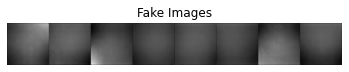

#0 | Probability from true distribution: 2.34264
#1 | Probability from true distribution: 1.70415
#2 | Probability from true distribution: 1.45129
#3 | Probability from true distribution: 2.13417
#4 | Probability from true distribution: 2.06790
#5 | Probability from true distribution: 1.97594
#6 | Probability from true distribution: 0.86157
#7 | Probability from true distribution: 2.39697




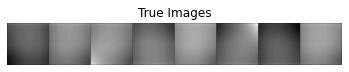

#0 | Probability from false distribution: 3.65529
#1 | Probability from false distribution: 2.95170
#2 | Probability from false distribution: 2.44041
#3 | Probability from false distribution: 2.80483
#4 | Probability from false distribution: 2.53241
#5 | Probability from false distribution: 4.74377
#6 | Probability from false distribution: 3.28619
#7 | Probability from false distribution: 2.66418


In [ ]:
num_imgs = 8

###### Plot False Images

#fake_fixed = netG(fixed_noise)
noise = torch.randn(num_imgs, nz, 1, 1, device=device)
fake_rand = generator(noise).detach().cpu()

#plt.imshow(np.transpose(vutils.make_grid(fake_rand, padding=2, normalize=True)))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_rand.to(device)[:num_imgs], padding=1, normalize=True).cpu(),(1,2,0)))
#plt.imshow(np.transpose(vutils.make_grid(fake_rand.to(device)[:num_imgs], padding=1).cpu(),(1,2,0)))
probability = discriminator(generator(noise))
plt.show()

for i in range(probability.size()[0]):
  print('#{} | Probability from true distribution: {:.5f}'.format(i, float(probability[i])))

###### Plot True Images
print('\n')

#plt.imshow(np.transpose(vutils.make_grid(fake_rand, padding=2, normalize=True)))
real_batch = next(iter(dataloader))

plt.axis("off")
plt.title("True Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:num_imgs], padding=1, normalize=True).cpu(),(1,2,0)))
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:num_imgs], padding=1).cpu(),(1,2,0)))
probability = discriminator(real_batch[0].to(device)[:num_imgs])
plt.show()

for i in range(probability.size()[0]):
  print('#{} | Probability from false distribution: {:.5f}'.format(i, float(probability[i])))

### Mean of Many

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


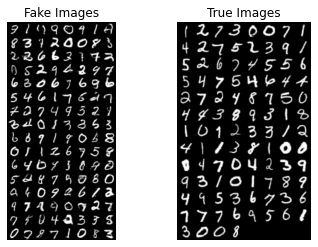

Mean probability from false distribution (128 images): 1.05965
Mean probability from true distribution (128 images): 3.37736


In [ ]:
num_imgs_fake = 128
num_imgs_true = 128

###### Plot False Images

#fake_fixed = netG(fixed_noise)
noise = torch.randn(num_imgs_fake, nz, 1, 1, device=device)
fake_rand = generator(noise).detach().cpu()

#plt.imshow(np.transpose(vutils.make_grid(fake_rand, padding=2, normalize=True)))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Fake Images")
#plt.imshow(np.transpose(vutils.make_grid(fake_rand.to(device)[:num_imgs_fake], padding=1, normalize=True).cpu(),(1,2,0)))
plt.imshow(np.transpose(vutils.make_grid(fake_rand.to(device)[:num_imgs_fake], padding=1).cpu(),(1,2,0)))
probability = discriminator(generator(noise))

mean_prob_false = probability.mean()

###### Plot True Images
print('\n')
real_batch = next(iter(dataloader))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("True Images")
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:num_imgs_true], padding=1, normalize=True).cpu(),(1,2,0)))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:num_imgs_true], padding=1).cpu(),(1,2,0)))
probability = discriminator(real_batch[0].to(device)[:num_imgs_true])
plt.show()

mean_prob_true = probability.mean()

print('Mean probability from false distribution ({} images): {:.5f}'.format(num_imgs_fake, float(mean_prob_false)))
print('Mean probability from true distribution ({} images): {:.5f}'.format(num_imgs_true, float(mean_prob_true)))

## Test Data Loader

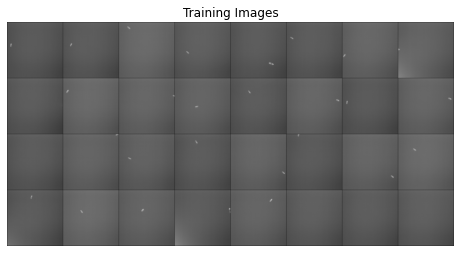

In [24]:
#cracked_root = "/content/Ano_land"
cracked_root = "/content/Ano_object"
#cracked_root = "/content/True"
batch_size = 128

#dataset_cracked = dset.ImageFolder(root=cracked_root,
#                           transform=transforms.Compose([
#                               transforms.Resize(image_size),
#                               transforms.CenterCrop(image_size),
#                               transforms.ToTensor(),
#                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                           ]))

### EGET SETT - Normalized
dataset_test = dset.ImageFolder(root=cracked_root,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5], std=[0.5]),
                           ]))
'''
dataset_test = dset.ImageFolder(root=cracked_root,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                           ]))

dataset_test = dset.MNIST('/content/', download=True, train=False,
                           transform=transforms.Compose([
                               transforms.Grayscale(num_output_channels=1),
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor()
                           ]))
'''

# Create the dataloader
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
cracked_batch = next(iter(dataloader_test))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(cracked_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

### All Three

In [21]:
num_imgs_cracked = 4
num_imgs_true = 4
num_imgs_fake = 4


###### Plot False Images

noise = torch.randn(num_imgs_fake, nz, 1, 1, device=device)
fake_rand = netG(noise).detach().cpu()

#plt.imshow(np.transpose(vutils.make_grid(fake_rand, padding=2, normalize=True)))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_rand.to(device)[:num_imgs_fake], padding=1, normalize=True).cpu(),(1,2,0)))
probability = netD(netG(noise))
plt.show()

mean_prob_false = probability.mean()
print('Mean probability from true distribution ({} images): {:.5f}'.format(num_imgs_fake, float(mean_prob_false)))


###### Plot Cracked Images

print('\n')
cracked_batch = next(iter(dataloader_cracked))

#plt.imshow(np.transpose(vutils.make_grid(fake_rand, padding=2, normalize=True)))
plt.axis("off")
plt.title("Cracked Images")
plt.imshow(np.transpose(vutils.make_grid(cracked_batch[0].to(device)[:num_imgs_cracked], padding=1, normalize=True).cpu(),(1,2,0)))
probability = netD(cracked_batch[0].to(device)[:num_imgs_cracked])
plt.show()

mean_prob_cracked = probability.mean()
print('Mean probability from true distribution ({} images): {:.5f}'.format(num_imgs_cracked, float(mean_prob_cracked)))


###### Plot True Images

print('\n')
real_batch = next(iter(dataloader))

plt.axis("off")
plt.title("True Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:num_imgs_true], padding=1, normalize=True).cpu(),(1,2,0)))
probability = netD(real_batch[0].to(device)[:num_imgs_true])
plt.show()

mean_prob_true = probability.mean()
print('Mean probability from true distribution ({} images): {:.5f}'.format(num_imgs_true, float(mean_prob_true)))

NameError: ignored

## Walk

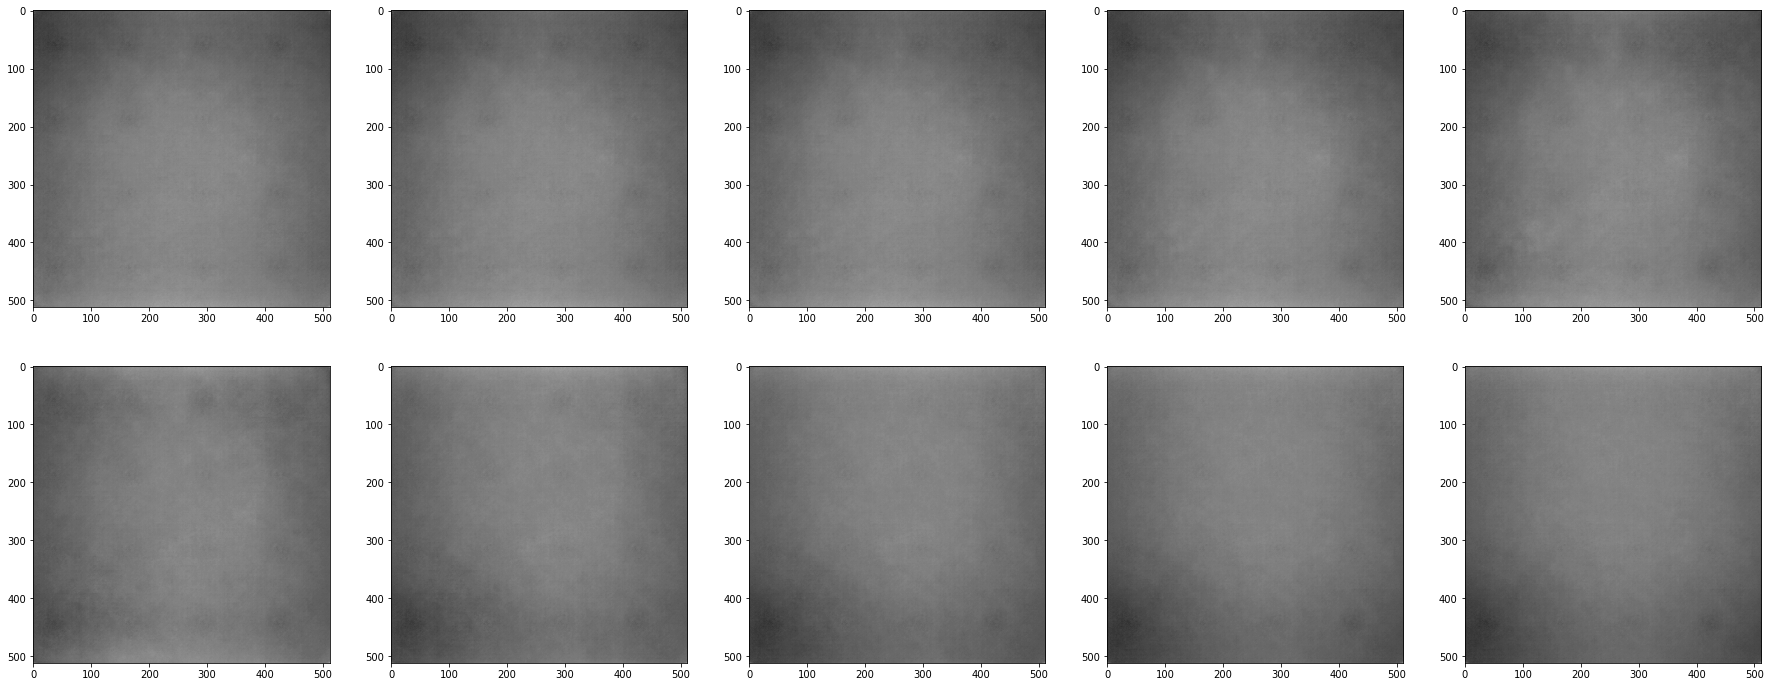

In [74]:
#a =torch.randn(b_size, nz, 1, 1, device=device)

start= a[23:24]
end= a[13:16]
r1= 0.92*start + 0.08*end
r2= 0.875*start + 0.125*end
r3= 0.75*start + 0.25*end
r4= 0.625*start + 0.375*end
r5= 0.5*start + 0.5*end
r6= 0.375*start + 0.625*end
r7= 0.25*start + 0.75*end
r8= 0.125*start + 0.875*end

fake_rand = generator(start).detach().cpu()

plt.figure(figsize=(31,12))
min_ = fake_rand.to(device)[0][0].cpu().min()-0.05
max_ = fake_rand.to(device)[0][0].cpu().max()+0.05

fake_rand = generator(start).detach().cpu()
plt.subplot(2,5,1)
plt.imshow(fake_rand.to(device)[0][0].cpu(), cmap='gray',vmin=min_,vmax=max_)

fake_rand = generator(r1).detach().cpu()
plt.subplot(2,5,2)
plt.imshow(fake_rand.to(device)[0][0].cpu(), cmap='gray',vmin=min_,vmax=max_)

fake_rand = generator(r2).detach().cpu()
plt.subplot(2,5,3)
plt.imshow(fake_rand.to(device)[0][0].cpu(), cmap='gray',vmin=min_,vmax=max_)

fake_rand = generator(r3).detach().cpu()
plt.subplot(2,5,4)
plt.imshow(fake_rand.to(device)[0][0].cpu(), cmap='gray',vmin=min_,vmax=max_)

fake_rand = generator(r4).detach().cpu()
plt.subplot(2,5,5)
plt.imshow(fake_rand.to(device)[0][0].cpu(), cmap='gray',vmin=min_,vmax=max_)

fake_rand = generator(r5).detach().cpu()
plt.subplot(2,5,6)
plt.imshow(fake_rand.to(device)[0][0].cpu(), cmap='gray',vmin=min_,vmax=max_)

fake_rand = generator(r6).detach().cpu()
plt.subplot(2,5,7)
plt.imshow(fake_rand.to(device)[0][0].cpu(), cmap='gray',vmin=min_,vmax=max_)

fake_rand = generator(r7).detach().cpu()
plt.subplot(2,5,8)
plt.imshow(fake_rand.to(device)[0][0].cpu(), cmap='gray',vmin=min_,vmax=max_)

fake_rand = generator(r8).detach().cpu()
plt.subplot(2,5,9)
plt.imshow(fake_rand.to(device)[0][0].cpu(), cmap='gray',vmin=min_,vmax=max_)

fake_rand = generator(end).detach().cpu()
plt.subplot(2,5,10)
plt.imshow(fake_rand.to(device)[0][0].cpu(), cmap='gray',vmin=min_,vmax=max_)

## Anomaly

In [37]:
import shutil
import cv2
!mkdir /content/ano_plot

In [38]:
def anomaly_score(x,G_z,Lambda=0.1):
    x_feature = discriminator.feature_forward(x)
    G_z_feature = discriminator.feature_forward(G_z)
    
    residual_loss = torch.sum(torch.abs(G_z-x))
    #discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature))
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature))

    median_loss = torch.median(torch.abs(x_feature-G_z_feature))
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss, residual_loss, discrimination_loss

In [39]:
def plot_batch(cracked_batch, noise, batch_size, i):
    fake_batch = generator(noise)

    created_img = fake_batch.to(device)[:1].cpu().detach().numpy()[0,0,:,:]
    objective_img = cracked_batch[0].cpu().detach().numpy()[0,:,:]

    min_ = objective_img.min()
    max_ = objective_img.max()
    print('min: {:.2f}'.format(min_))
    print('max: {:.2f}'.format(max_))
    
    #min_ = -0.5
    #max_ = 0.5

    residual = objective_img - created_img

    plt.figure(figsize=(21, 21))
    plt.subplot(2,2,1)
    plt.imshow(objective_img, cmap='gray', vmin = min_, vmax = max_)
    plt.colorbar()

    plt.subplot(2,2,2)
    plt.imshow(created_img, cmap='gray', vmin = min_, vmax = max_)
    plt.colorbar()

    plt.subplot(2,2,3)
    plt.imshow(residual, cmap='gray', vmin = min_, vmax = max_)
    plt.colorbar()

    residual_offset = residual
    plt.subplot(2,2,4)
    residual_thrsh = cv2.threshold(residual_offset, 0.05,10,cv2.THRESH_BINARY)
    plt.imshow(residual_thrsh[1], cmap='gray')

    plt.show()

### Attempt loop

min: -0.20
max: 0.23


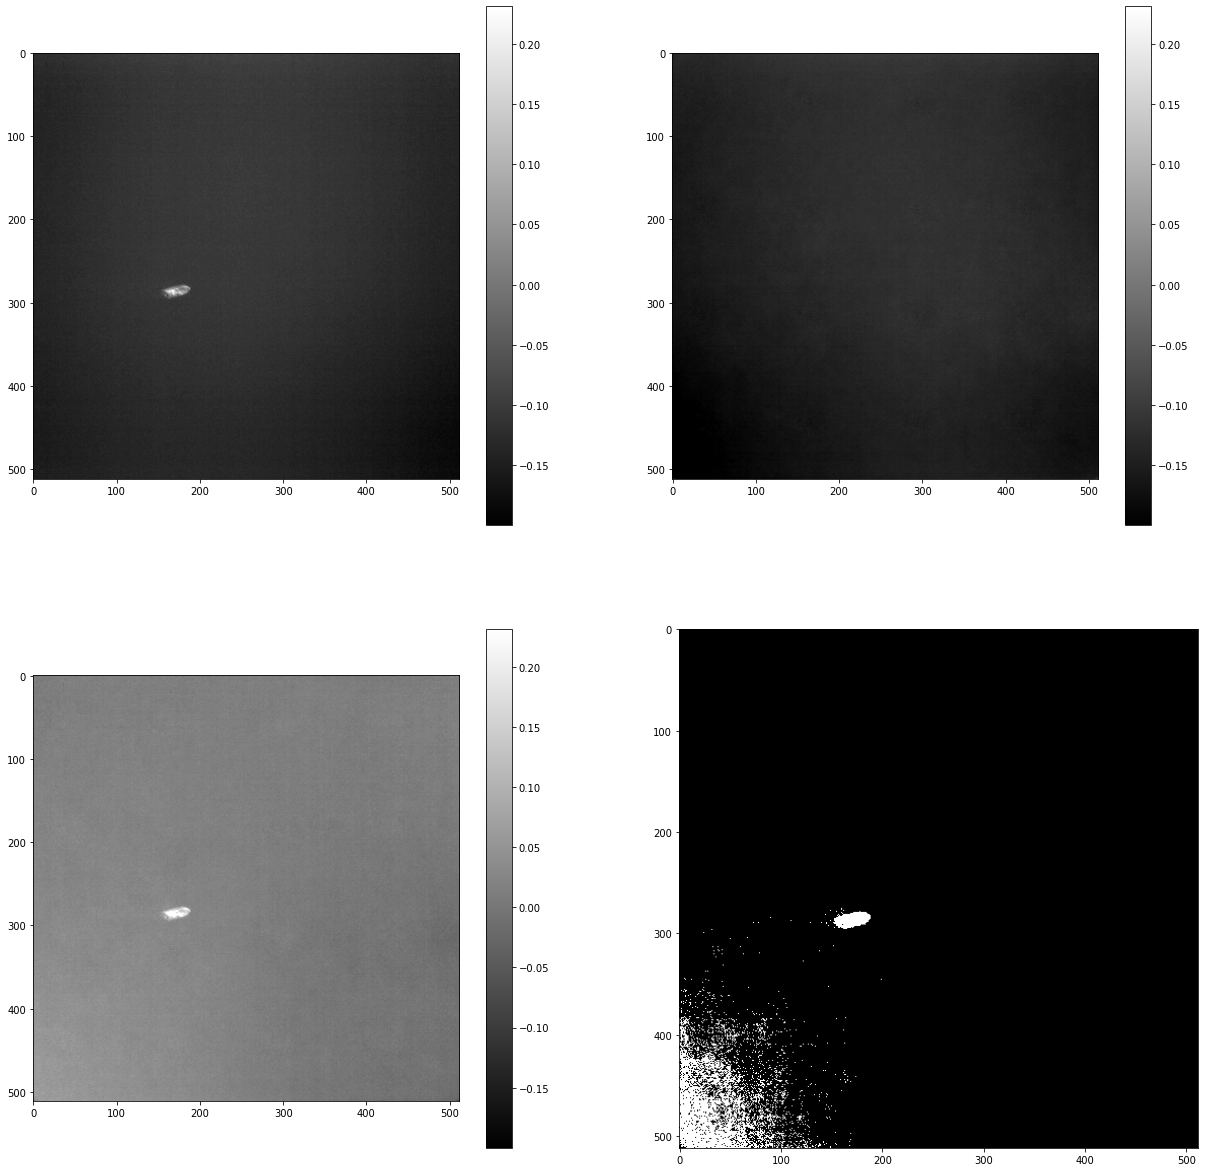

In [ ]:
from torch.autograd import Variable
from IPython.display import clear_output

# INITIALIZE
batch_size = 1
Lambda = 0.3

cracked_batch = next(iter(dataloader_test))[0].to(device)[:batch_size]
noise = Variable(torch.randn(batch_size, nz, 1, 1, device=device), requires_grad=True)

lr= 0.01
noise_optimizer = optim.Adam([noise], lr=lr)
i = 0
plot_batch1(cracked_batch, noise, batch_size, i)

loss_list = []
res_loss_list = []
disc_loss_list = []

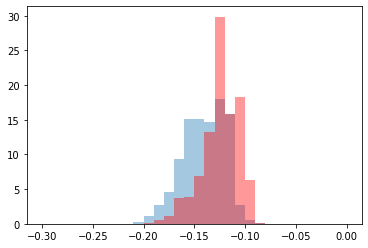

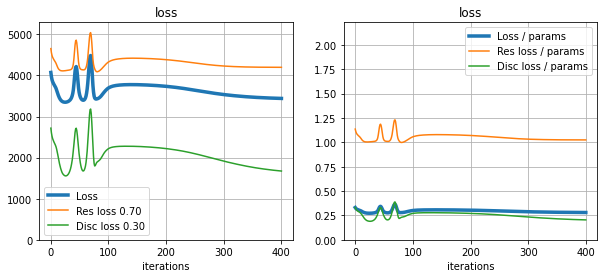

min: -0.20
max: 0.23


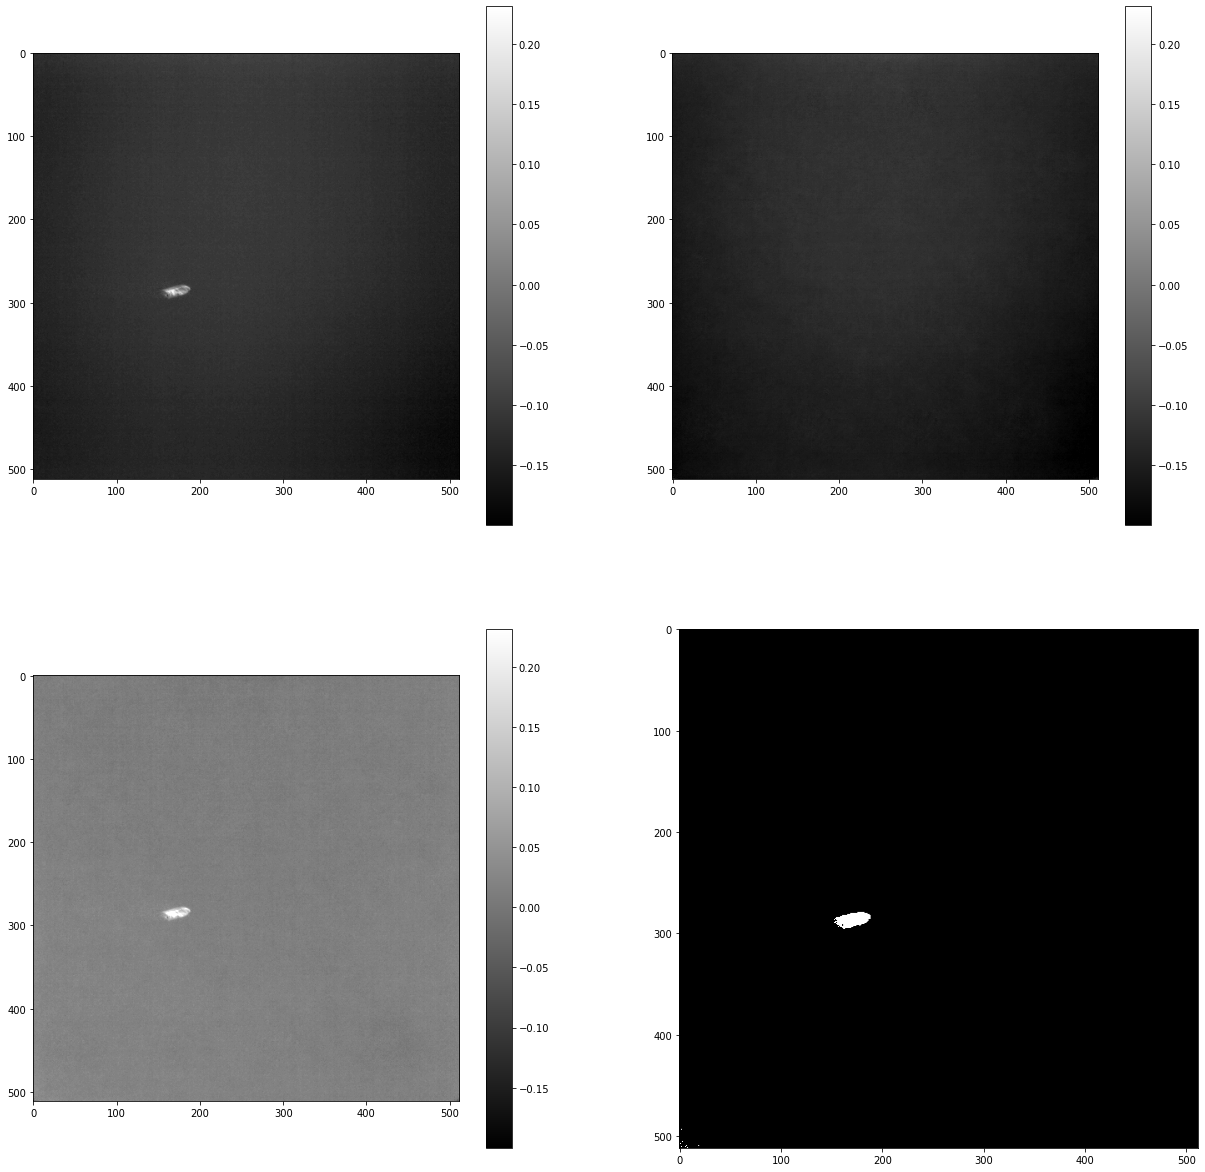

In [ ]:
#noise_optimizer = optim.Adam([noise], lr=0.005)
lr = 0.005
Lambda= 0.3

noise_optimizer = optim.Adam([noise], lr=lr)
if os.path.exists('ano_plot'):
  shutil.rmtree('ano_plot')
os.makedirs('ano_plot')


for i in range(500):
    fake_batch = generator(noise)
    loss, res_loss, disc_loss = anomaly_score(Variable(cracked_batch).cuda(), fake_batch, Lambda=Lambda)
    loss.backward()
    noise_optimizer.step()
    loss_list.append(float(loss.clone().detach().cpu().numpy()))
    res_loss_list.append(float(res_loss.clone().detach().cpu().numpy()))
    disc_loss_list.append(float(disc_loss.clone().detach().cpu().numpy()))
    
    if i%100==0:
        print(loss.cpu().data)
        print(i)

    if i%100==0:
        clear_output(wait=True)
        #plot_batch1(cracked_batch, noise, batch_size, i)
        #plt.show()

        #clear_output(wait=True)
        #plot_batch(cracked_batch, noise, batch_size, i)
        #plt.show()
        plt.figure()
        #objective_img = cracked_batch[0].cpu().detach().numpy()[0,:,:]

        #hist, edges = np.histogram(fake_batch.to(device)[:1].cpu().detach().numpy()[0,0,:,:].flatten(), 
        #                           density=True,   range=(-0.5,0.5) )

        plt.hist(fake_batch.to(device)[:1].clone().cpu().detach().numpy()[0,0,:,:].flatten(), bins=30, density=True,
                 range=(-0.3,0.), alpha=0.4)
        plt.hist(cracked_batch[0].cpu().detach().numpy()[0,:,:].flatten(), bins=30, color='r', density=True,
                 range=(-0.3,0.), alpha=0.4)

        plt.show()

        ## Loss
        plt.figure(figsize=(10, 4))

        plt.subplot(1,2,1)
        plt.plot(loss_list, label='Loss', linewidth=3.5)
        plt.plot(res_loss_list, label='Res loss {:.2f}'.format(1-Lambda))
        plt.plot(disc_loss_list, label='Disc loss {:.2f}'.format(Lambda))
        plt.legend()
        plt.title('loss')
        plt.grid()
        plt.ylim([0,max([*loss_list, *res_loss_list, *disc_loss_list])+250])
        plt.xlabel('iterations') 
        plt.ylabel('')

        ## Loss per param
        plt.subplot(1,2,2)
        loss_per_param = np.divide(loss_list,(4*4*512+64*64))
        loss_res_per_param = np.divide(res_loss_list,(64*64))
        loss_disc_per_param = np.divide(disc_loss_list,(4*4*512))

        plt.plot(loss_per_param, label='Loss / params', linewidth=3.5)
        plt.plot(loss_res_per_param, label='Res loss / params')
        plt.plot(loss_disc_per_param, label='Disc loss / params')
        plt.legend()
        plt.title('loss')
        plt.grid()
        plt.ylim([0,max([*loss_per_param, *loss_res_per_param, *loss_disc_per_param])+1])
        plt.xlabel('iterations')
        plt.ylabel('')
        plt.savefig('ano_plot/ano_loss.png')
        plt.show()

plot_batch1(cracked_batch, noise, batch_size, i)
plt.show()

### Loop Trial

In [40]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from PIL import Image
import shutil
import pandas as pd
import cv2
from IPython.display import clear_output
import os
from sklearn import preprocessing
import matplotlib.patches as patches
import time

In [41]:
%mkdir -p /content/Eval_Data
!cp /content/MyDrive/MyDrive/0-MasterThesis/Eval_Data.zip /content/Eval_Data
%cd /content/Eval_Data/
!unzip Eval_Data.zip
%cd /content/

Streaming output truncated to the last 5000 lines.
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01895.png  
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01896.png  
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01897.png  
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01898.png  
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01899.png  
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01900.png  
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01901.png  
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01902.png  
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01903.png  
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01904.png  
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01905.png  
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01906.png  
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01907.png  
  inflating: Haak_data/Flight3/20170926_norm_1100-3900/01908.png  
  inflating

In [57]:
Haak1_true_df = pd.read_csv(r'/content/Eval_Data/Haak_data/Flight1/Haak1_true_annot.csv')
Haak1_anomalies_object_df = pd.read_csv(r'/content/Eval_Data/Haak_data/Flight1/Haak1_ano_object_annot.csv')
Haak1_anomalies_land_df = pd.read_csv(r'/content/Eval_Data//Haak_data/Flight1/Haak1_ano_land_annot.csv')

Haak3_true_df = pd.read_csv(r'/content/Eval_Data//Haak_data/Flight3/Haak3_true_annot.csv')
Haak3_anomalies_object_df = pd.read_csv(r'/content/Eval_Data//Haak_data/Flight3/Haak3_ano_object_annot.csv')
Haak3_anomalies_land_df = pd.read_csv(r'/content/Eval_Data//Haak_data/Flight3/Haak3_ano_land_annot.csv')

Danilo_true_df = pd.read_csv(r'/content/Eval_Data//Danilo_data/IR/Danilo_true_annot.csv')
Danilo_anomalies_land_df = pd.read_csv(r'/content/Eval_Data/Danilo_data/IR/Danilo_ano_land_annot.csv')
Empty_df = pd.read_csv(r'/content/Eval_Data/Danilo_data/IR/Empty.csv')

# Haak - Flight 1
Haak1_true_train       = Haak1_true_df.sample(frac = 0.7, random_state = 100)
Haak1_true_test        = Haak1_true_df.drop(Haak1_true_train.index)

Haak1_ano_object_train = Haak1_anomalies_object_df.sample(frac = 0.7, random_state = 100)
Haak1_ano_object_test  = Haak1_anomalies_object_df.drop(Haak1_ano_object_train.index)

Haak1_ano_land_train   = Haak1_anomalies_land_df.sample(frac = 0.7, random_state = 100)
Haak1_ano_land_test    = Haak1_anomalies_land_df.drop(Haak1_ano_land_train.index)
 
# Haak - Flight 1
Haak3_true_test        = Haak3_true_df
Haak3_ano_object_test  = Haak3_anomalies_object_df
Haak3_ano_land_test    = Haak3_anomalies_land_df

# Danilo
Danilo_true_test       = Danilo_true_df
Danilo_ano_land_test   = Danilo_anomalies_land_df
empty                  = Empty_df

In [75]:
def covering_rectangle_from_square_boxes(boxes):
    output = np.array([])
    
    if len(boxes):
        x_left = np.min(boxes[:,0])
        width = np.max(boxes[:,0] + boxes[:,2] - x_left)
        y_top = np.min(boxes[:,1])
        height = np.max(boxes[:,1] + boxes[:,3] - y_top)
        
        output = np.array([[x_left, y_top, width, height]])

    return output

def intersection_info(box_i, box_j):
    # NMS
    x_left_i, y_upper_i, w_i, h_i = box_i
    x_right_i = x_left_i + w_i
    y_lower_i = y_upper_i + h_i
    area_i = w_i*h_i

    x_left_j, y_upper_j, w_j, h_j = box_j
    x_right_j = x_left_j + w_j
    y_lower_j = y_upper_j + h_j
    area_j = w_j*h_j

    x_left  = max(x_left_i, x_left_j)
    y_upper = max(y_upper_i, y_upper_j)

    x_right = min(x_right_i, x_right_j)
    y_lower = min(y_lower_i, y_lower_j)

    w_intersec = max(0, x_right - x_left)
    h_intersec = max(0, y_lower - y_upper)

    intersection_area = w_intersec*h_intersec
    union_area = area_i + area_j - intersection_area
    IoU = intersection_area / union_area
    
    return list([x_left, y_upper, w_intersec, h_intersec, intersection_area, union_area, IoU, area_i, area_j])

def compare_predictions_with_truth(pred_boxes, true_boxes):
    
    intersection_boxes = []
    match_found_pred = np.ones(len(pred_boxes))
    match_found_true = np.ones(len(true_boxes))
    
    for i, box_pred in enumerate(pred_boxes):
        for j, box_true in enumerate(true_boxes):
                     
            x_left, y_upper, w_intsc, h_intsc, A_intsc, A_union, IoU, A_pred, A_true  = intersection_info(box_pred, box_true)
            
            if IoU >= 0.1:
                match_found_pred[i] = 0
                match_found_true[j] = 0
                intersection_boxes = [*intersection_boxes, [x_left, y_upper, w_intsc, h_intsc]]
            
            elif (IoU >= 0.05) and ((A_intsc>=A_pred) or (A_intsc>=A_true)):
                match_found_pred[i] = 0
                match_found_true[j] = 0
                intersection_boxes = [*intersection_boxes, [x_left, y_upper, w_intsc, h_intsc]]
            
            
    intersection_boxes = np.array(intersection_boxes)
        
    false_positives = match_found_pred.sum()
    false_negatives = match_found_true.sum()
    true_positives  = len(match_found_true) - false_negatives
                
    return intersection_boxes, false_positives, false_negatives, true_positives

def boxes_from_mask(mask, area_threshold):
    
    contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, 2)
    
    # Threshold by area
    contours_areathrsh = []
    for cnt in contours:
        if cv2.contourArea(cnt) > area_threshold:
            contours_areathrsh = [*contours_areathrsh, cnt]
    contours_areathrsh = np.array(contours_areathrsh)
    
    # combine boxes thresholded
    boxes = []
    for i, cnt in enumerate(contours_areathrsh):
        box = cv2.boundingRect(cnt)
        boxes = [*boxes, box]
    boxes = np.array(boxes)

    return boxes

def plot_results(img, mask, pred_boxes, true_boxes, intersection_boxes, title):
    colors = ['r', 'c', 'g', 'b', 'y', 'm']
    
    clear_output(wait=True)
    fig = plt.figure(figsize=(21,10))

    # Plot boxes - Area thresholded
    plt.subplot(1,2,1)
    plt.imshow(mask, cmap='gray')
    ax = plt.gca()
    
    plt.subplot(1,2,2)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    ax = plt.gca()

    for i, box in enumerate(intersection_boxes):
        x,y,w,h = box # upper left
        rect = patches.Rectangle((x,y), w,h, edgecolor='y', facecolor='y', fill=True, linewidth=2, alpha=0.25)
        ax.add_patch(rect)     
    
    for i, box in enumerate(pred_boxes):
        x,y,w,h = box # upper left
        rect = patches.Rectangle((x,y), w,h, edgecolor='r', fill=False, linewidth=2)
        ax.add_patch(rect)
        
    for i, box in enumerate(true_boxes):
        x,y,w,h = box # upper left
        rect = patches.Rectangle((x,y), w,h, edgecolor='g', fill=False, linewidth=2)
        ax.add_patch(rect)           
        
     
    fig.suptitle(title + ' | Found: {}, Truth: {}'.format(len(pred_boxes), len(true_boxes)), fontsize=18)
    plt.show()


def plot_img(objective_img, noise):
    fake_img_t = generator(noise)

    fake_img = fake_img_t.to(device)[:1].cpu().detach().numpy()[0,0,:,:]

    #min_ = objective_img.min()
    #max_ = objective_img.max()
    print('min: {:.2f}'.format(min_))
    print('max: {:.2f}'.format(max_))
    
    #min_ = -0.5
    #max_ = 0.5

    residual = objective_img - fake_img

    plt.subplot(2,2,1)
    plt.imshow(objective_img, cmap='gray', vmin = min_, vmax = max_)
    plt.colorbar()

    plt.subplot(2,2,2)
    plt.imshow(fake_img, cmap='gray', vmin = min_, vmax = max_)
    plt.colorbar()

    plt.subplot(2,2,3)
    plt.imshow(residual, cmap='gray', vmin = min_, vmax = max_)
    plt.colorbar()

    plt.subplot(2,2,4)
    residual_thrsh = cv2.threshold(residual, 0.11,10,cv2.THRESH_BINARY)[1]
    plt.imshow(residual_thrsh, cmap='gray')


def plot_progress(objective_img, fake_img, noise, loss_list, res_loss_list, disc_loss_list):

  plt.figure(figsize=(34,14))

  ## Loss
  plt.subplot(2,3,1)

  plt.plot(loss_list, label='Loss', linewidth=3.5)
  plt.plot(res_loss_list, label='Res loss {:.2f}'.format(1-Lambda))
  plt.plot(disc_loss_list, label='Disc loss {:.2f}'.format(Lambda))
  plt.legend()
  plt.title('loss')
  plt.grid()
  plt.ylim([0, max([*loss_list, *res_loss_list, *disc_loss_list]) + 250])
  plt.xlabel('iterations') 
  plt.ylabel('')

  #######
  plt.subplot(2,3,4)
  plt.hist(fake_img.flatten(), bins=30, density=True,
          range=(-0.3,0.), alpha=0.4)
  plt.hist(objective_img.flatten(), bins=30, color='r', density=True,
          range=(-0.3,0.), alpha=0.4)

  #######

  #min_ = objective_img.min()
  #max_ = objective_img.max()
  #print('min: {:.2f}'.format(min_))
  #print('max: {:.2f}'.format(max_))
  
  #min_ = -0.5
  #max_ = 0.5

  residual = np.abs(objective_img - fake_img)

  plt.subplot(2,3,2)
  plt.imshow(objective_img, cmap='gray', vmin = min_, vmax = max_)
  plt.colorbar()

  plt.subplot(2,3,3)
  plt.imshow(fake_img, cmap='gray', vmin = min_, vmax = max_)
  plt.colorbar()

  plt.subplot(2,3,5)
  plt.imshow(residual, cmap='gray')
  plt.colorbar()

  plt.subplot(2,3,6)
  residual_thrsh = cv2.threshold(residual, 0.11,10,cv2.THRESH_BINARY)[1]
  #residual_thrsh = cv2.threshold(np.array(residual, dtype=np.uint8), 0, 0.2, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
  plt.imshow(residual_thrsh, cmap='gray')


  plt.show()

In [77]:
from torch.autograd import Variable
from IPython.display import clear_output

def AnoGAN_inference(objective_img_t, doPlots):
    i = 0
    Lambda= 0.1
    lr = 0.1
    noise1 = Variable(torch.randn(1, nz, 1, 1, device=device), requires_grad=True)
    noise2 = Variable(torch.randn(1, nz, 1, 1, device=device), requires_grad=True)
    noise = Variable(torch.randn(1, nz, 1, 1, device=device), requires_grad=True)
    noise_optimizer = optim.Adam([noise], lr=lr)

    loss_list = []
    res_loss_list = []
    disc_loss_list = []

    for i in range(1000):

        if (i%200==0)and (i != 0):
          lr = lr / 2
          noise_optimizer = optim.Adam([noise], lr=lr)

          

        fake_img_t = generator(noise)
        loss, res_loss, disc_loss = anomaly_score(Variable(objective_img_t).cuda(), fake_img_t, Lambda=Lambda)

        loss.backward()
        noise_optimizer.step()

        loss_list.append(float(loss.clone().detach().cpu().numpy()))
        res_loss_list.append(float(res_loss.clone().detach().cpu().numpy()))
        disc_loss_list.append(float(disc_loss.clone().detach().cpu().numpy()))
        
        if i%100==0:
          print(loss.cpu().data)
          #print(i)
          
          if doPlots:
            fake_img_t = generator(noise)

            fake_img_t_copy = fake_img_t
            fake_img = fake_img_t_copy.to(device)[:1].cpu().detach().numpy()[0,0,:,:]

            objective_img_copy = objective_img_t
            objective_img = objective_img_copy.cpu().detach().numpy()[0,:,:]

            residual_img = objective_img - fake_img


            plot_progress(objective_img, fake_img, noise, loss_list, res_loss_list, disc_loss_list)


    fake_img_t = generator(noise)
    fake_img = fake_img_t.to(device)[:1].cpu().detach().numpy()[0,0,:,:]
    objective_img = objective_img_t.cpu().detach().numpy()[0,:,:]
    residual_img = objective_img - fake_img

    return fake_img, objective_img, residual_img, loss_list, res_loss_list, disc_loss_list

In [78]:
def run_AnoGAN(img_dir, true_df, object_df, land_df):
    
    #####################################################
    testObjects = True
    testLand = True
    testTrue = True
    Lambda= 0.1
    doPlots = True
    #####################################################

    files = os.listdir(img_dir)
    n_files = len(files)

    loops = n_files
    loops = 10

    object_metrics = {'FPs':0, 'FNs':0, 'TPs': 0}
    land_metrics   = {'FPs':0, 'FNs':0, 'TPs': 0}
    true_metrics   = {'FPs':0, 'FNs':0, 'TPs': 0}

    scenery = ''
    loss_all_img = []
    residual_all_img = []

    for i, file in enumerate(files[:loops]):
        print('i: ', str(i), 'file: ', file)
        true_boxes = []
        pred_boxes = []
        intersection_boxes = []
        FP, FN, TP = 0,0,0

        if i>0 and true_df['file'].str.contains(file).sum():
            print('#### NEW IMAGE ####')
            img = Image.open(os.path.join(img_dir, file))
            img_numpy = np.array(Image.open(os.path.join(img_dir, file)))

            isAnomObject = object_df['file'].str.contains(file).sum()
            isAnomLand   = land_df['file'].str.contains(file).sum()
            isTrue       = true_df['file'].str.contains(file).sum()

            ##################### ALGORITHM #####################
            t = transforms.Compose([
                        transforms.Grayscale(num_output_channels=1),
                        transforms.Resize(image_size),
                        transforms.CenterCrop(image_size),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5]),
                        ])
            

            objective_img_t = t(img)

            fake_img, objective_img, residual_img, loss_list, res_loss_list, disc_loss_list = AnoGAN_inference(objective_img_t, doPlots)
            print('final loss: ', str(loss_list[-1]))

            residual_all_img = [*residual_all_img, residual_img]
            loss_all_img = [*loss_all_img, loss_list[-1]]

            #plot_batch(objective_img, noise)
            #plt.show()

            time.sleep(5)

            '''
            #####################################################
            if isAnomObject and testObjects:
                scenery = 'Object'
                true_boxes = object_df[object_df['file'] == file]
                true_boxes = true_boxes[['x','y','w','h']].to_numpy()      
            elif isAnomLand and testLand:
                scenery = 'Land'
                true_boxes = land_df[land_df['file'] == file]
                true_boxes = true_boxes[['x','y','w','h']].to_numpy()       
            elif isTrue and testTrue:
                scenery = 'Nothing'
            else:
                scenery = 'Error'
                continue

            # Pred Boxes
            pred_boxes = boxes_from_mask(mask, area_threshold)

            if isAnomLand:
                pred_boxes = covering_rectangle_from_square_boxes(pred_boxes) # Combine small boxes

            # Calculate accuracy
            intersection_boxes, FP, FN, TP = compare_predictions_with_truth(pred_boxes, true_boxes)

            # Metrics
            if isAnomObject and testObjects: 
                update = {'FPs':FP, 'FNs':FN, 'TPs': TP}
                object_metrics = {i: object_metrics.get(i, 0) + update.get(i, 0) for i in set(update)}
            elif isAnomLand and testLand:
                update = {'FPs':FP, 'FNs':FN, 'TPs': TP}
                land_metrics = {i: land_metrics.get(i, 0) + update.get(i, 0) for i in set(update)}
            elif isTrue and testTrue:
                update = {'FPs':FP, 'FNs':FN, 'TPs': TP}
                true_metrics = {i: true_metrics.get(i, 0) + update.get(i, 0) for i in set(update)}

            # Plot
            title = 'FP: {}, FN: {}, TP: {} | {}'.format(FP, FN, TP, scenery)

            if doPlots:
                plot_results(img, mask, pred_boxes, true_boxes, intersection_boxes, title)
                
            print('{}/{}'.format(int(file.split('.')[0]), n_files), end='\r')
            '''

    return np.array(residual_all_img), np.array(loss_all_img)
             
    print('Object: {}'.format(object_metrics))
    print('Recall: {:.4f}'.format(object_metrics['TPs']/(object_metrics['FNs']+object_metrics['TPs']+0.00000001)))
    print('Precision: {:.4f}'.format(object_metrics['TPs']/(object_metrics['FPs']+object_metrics['TPs']+0.00000001)))
    print('--------')
    print('Land: {}'.format(land_metrics))
    print('Recall: {:.4f}'.format(land_metrics['TPs']/(land_metrics['FNs']+land_metrics['TPs']+0.00000001)))
    print('Precision: {:.4f}'.format(land_metrics['TPs']/(land_metrics['FPs']+land_metrics['TPs']+0.00000001)))
    print('--------')
    print('True: {}'.format(true_metrics))
    print('Recall: {:.4f}'.format(true_metrics['TPs']/(true_metrics['FNs']+true_metrics['TPs']+0.00000001)))
    print('Precision: {:.4f}'.format(true_metrics['TPs']/(true_metrics['FPs']+true_metrics['TPs']+0.00000001)))

In [79]:
img_dir = '/content/Eval_Data/Haak_data/Flight3/20170926_norm_1100-3900/'
Lambda = 0.1
residual_all_img, loss_all_img = run_AnoGAN(img_dir, Haak3_ano_object_test, Haak3_ano_object_test, Haak3_ano_land_test)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
residual_all_img5 = residual_all_img
loss_all_img5 = loss_all_img

In [47]:
fig = plt.figure(figsize=(32,8))
fig.suptitle('lr: 0.5 - random initializaton 1', fontsize = 18)

loss_all_img = loss_all_img1
residual_all_img = residual_all_img1

plt.subplot(2,10,1)
plt.title(str(loss_all_img[0]))
plt.imshow(residual_all_img[0], cmap='gray')

plt.subplot(2,10,2)
plt.title(str(loss_all_img[1]))
plt.imshow(residual_all_img[1], cmap='gray')

plt.subplot(2,10,3)
plt.title(str(loss_all_img[2]))
plt.imshow(residual_all_img[2], cmap='gray')

plt.subplot(2,10,4)
plt.title(str(loss_all_img[3]))
plt.imshow(residual_all_img[3], cmap='gray')

plt.subplot(2,10,5)
plt.title(str(loss_all_img[4]))
plt.imshow(residual_all_img[4], cmap='gray')

plt.subplot(2,10,6)
plt.title(str(loss_all_img[5]))
plt.imshow(residual_all_img[5], cmap='gray')

plt.subplot(2,10,7)
plt.title(str(loss_all_img[6]))
plt.imshow(residual_all_img[6], cmap='gray')

plt.subplot(2,10,8)
plt.title(str(loss_all_img[7]))
plt.imshow(residual_all_img[7], cmap='gray')

plt.subplot(2,10,9)
plt.title(str(loss_all_img[8]))
plt.imshow(residual_all_img[8], cmap='gray')

#plt.subplot(2,10,10)
#plt.title(str(loss_all_img[9]))
#plt.imshow(residual_all_img[9], cmap='gray')

plt.subplot(2,10,11)
plt.title(str(loss_all_img[0]))
plt.imshow(cv2.threshold(residual_all_img[0], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,12)
plt.title(str(loss_all_img[1]))
plt.imshow(cv2.threshold(residual_all_img[1], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,13)
plt.title(str(loss_all_img[2]))
plt.imshow(cv2.threshold(residual_all_img[2], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,14)
plt.title(str(loss_all_img[3]))
plt.imshow(cv2.threshold(residual_all_img[3], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,15)
plt.title(str(loss_all_img[4]))
plt.imshow(cv2.threshold(residual_all_img[4], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,16)
plt.title(str(loss_all_img[5]))
plt.imshow(cv2.threshold(residual_all_img[5], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,17)
plt.title(str(loss_all_img[6]))
plt.imshow(cv2.threshold(residual_all_img[6], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,18)
plt.title(str(loss_all_img[7]))
plt.imshow(cv2.threshold(residual_all_img[7], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,19)
plt.title(str(loss_all_img[8]))
plt.imshow(cv2.threshold(residual_all_img[8], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

#plt.subplot(2,10,20)
#plt.title(str(loss_all_img[9]))
#plt.imshow(cv2.threshold(residual_all_img[9], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.show()

###

fig = plt.figure(figsize=(32,8))
fig.suptitle('lr: 0.5 - random initializaton 2', fontsize = 18)

loss_all_img = loss_all_img2
residual_all_img = residual_all_img2

plt.subplot(2,10,1)
plt.title(str(loss_all_img[0]))
plt.imshow(residual_all_img[0], cmap='gray')

plt.subplot(2,10,2)
plt.title(str(loss_all_img[1]))
plt.imshow(residual_all_img[1], cmap='gray')

plt.subplot(2,10,3)
plt.title(str(loss_all_img[2]))
plt.imshow(residual_all_img[2], cmap='gray')

plt.subplot(2,10,4)
plt.title(str(loss_all_img[3]))
plt.imshow(residual_all_img[3], cmap='gray')

plt.subplot(2,10,5)
plt.title(str(loss_all_img[4]))
plt.imshow(residual_all_img[4], cmap='gray')

plt.subplot(2,10,6)
plt.title(str(loss_all_img[5]))
plt.imshow(residual_all_img[5], cmap='gray')

plt.subplot(2,10,7)
plt.title(str(loss_all_img[6]))
plt.imshow(residual_all_img[6], cmap='gray')

plt.subplot(2,10,8)
plt.title(str(loss_all_img[7]))
plt.imshow(residual_all_img[7], cmap='gray')

plt.subplot(2,10,9)
plt.title(str(loss_all_img[8]))
plt.imshow(residual_all_img[8], cmap='gray')

#plt.subplot(2,10,10)
#plt.title(str(loss_all_img[9]))
#plt.imshow(residual_all_img[9], cmap='gray')

plt.subplot(2,10,11)
plt.title(str(loss_all_img[0]))
plt.imshow(cv2.threshold(residual_all_img[0], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,12)
plt.title(str(loss_all_img[1]))
plt.imshow(cv2.threshold(residual_all_img[1], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,13)
plt.title(str(loss_all_img[2]))
plt.imshow(cv2.threshold(residual_all_img[2], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,14)
plt.title(str(loss_all_img[3]))
plt.imshow(cv2.threshold(residual_all_img[3], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,15)
plt.title(str(loss_all_img[4]))
plt.imshow(cv2.threshold(residual_all_img[4], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,16)
plt.title(str(loss_all_img[5]))
plt.imshow(cv2.threshold(residual_all_img[5], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,17)
plt.title(str(loss_all_img[6]))
plt.imshow(cv2.threshold(residual_all_img[6], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,18)
plt.title(str(loss_all_img[7]))
plt.imshow(cv2.threshold(residual_all_img[7], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,19)
plt.title(str(loss_all_img[8]))
plt.imshow(cv2.threshold(residual_all_img[8], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

#plt.subplot(2,10,20)
#plt.title(str(loss_all_img[9]))
#plt.imshow(cv2.threshold(residual_all_img[9], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.show()

###

fig = plt.figure(figsize=(32,8))
fig.suptitle('lr: 0.5 - random initializaton 3', fontsize = 18)

loss_all_img = loss_all_img3
residual_all_img = residual_all_img3

plt.subplot(2,10,1)
plt.title(str(loss_all_img[0]))
plt.imshow(residual_all_img[0], cmap='gray')

plt.subplot(2,10,2)
plt.title(str(loss_all_img[1]))
plt.imshow(residual_all_img[1], cmap='gray')

plt.subplot(2,10,3)
plt.title(str(loss_all_img[2]))
plt.imshow(residual_all_img[2], cmap='gray')

plt.subplot(2,10,4)
plt.title(str(loss_all_img[3]))
plt.imshow(residual_all_img[3], cmap='gray')

plt.subplot(2,10,5)
plt.title(str(loss_all_img[4]))
plt.imshow(residual_all_img[4], cmap='gray')

plt.subplot(2,10,6)
plt.title(str(loss_all_img[5]))
plt.imshow(residual_all_img[5], cmap='gray')

plt.subplot(2,10,7)
plt.title(str(loss_all_img[6]))
plt.imshow(residual_all_img[6], cmap='gray')

plt.subplot(2,10,8)
plt.title(str(loss_all_img[7]))
plt.imshow(residual_all_img[7], cmap='gray')

plt.subplot(2,10,9)
plt.title(str(loss_all_img[8]))
plt.imshow(residual_all_img[8], cmap='gray')

#plt.subplot(2,10,10)
#plt.title(str(loss_all_img[9]))
#plt.imshow(residual_all_img[9], cmap='gray')

plt.subplot(2,10,11)
plt.title(str(loss_all_img[0]))
plt.imshow(cv2.threshold(residual_all_img[0], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,12)
plt.title(str(loss_all_img[1]))
plt.imshow(cv2.threshold(residual_all_img[1], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,13)
plt.title(str(loss_all_img[2]))
plt.imshow(cv2.threshold(residual_all_img[2], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,14)
plt.title(str(loss_all_img[3]))
plt.imshow(cv2.threshold(residual_all_img[3], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,15)
plt.title(str(loss_all_img[4]))
plt.imshow(cv2.threshold(residual_all_img[4], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,16)
plt.title(str(loss_all_img[5]))
plt.imshow(cv2.threshold(residual_all_img[5], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,17)
plt.title(str(loss_all_img[6]))
plt.imshow(cv2.threshold(residual_all_img[6], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,18)
plt.title(str(loss_all_img[7]))
plt.imshow(cv2.threshold(residual_all_img[7], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,19)
plt.title(str(loss_all_img[8]))
plt.imshow(cv2.threshold(residual_all_img[8], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

#plt.subplot(2,10,20)
#plt.title(str(loss_all_img[9]))
#plt.imshow(cv2.threshold(residual_all_img[9], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.show()

###

fig = plt.figure(figsize=(32,8))
fig.suptitle('lr: 1 - random initializaton 3', fontsize = 18)

loss_all_img = loss_all_img4
residual_all_img = residual_all_img4

plt.subplot(2,10,1)
plt.title(str(loss_all_img[0]))
plt.imshow(residual_all_img[0], cmap='gray')

plt.subplot(2,10,2)
plt.title(str(loss_all_img[1]))
plt.imshow(residual_all_img[1], cmap='gray')

plt.subplot(2,10,3)
plt.title(str(loss_all_img[2]))
plt.imshow(residual_all_img[2], cmap='gray')

plt.subplot(2,10,4)
plt.title(str(loss_all_img[3]))
plt.imshow(residual_all_img[3], cmap='gray')

plt.subplot(2,10,5)
plt.title(str(loss_all_img[4]))
plt.imshow(residual_all_img[4], cmap='gray')

plt.subplot(2,10,6)
plt.title(str(loss_all_img[5]))
plt.imshow(residual_all_img[5], cmap='gray')

plt.subplot(2,10,7)
plt.title(str(loss_all_img[6]))
plt.imshow(residual_all_img[6], cmap='gray')

plt.subplot(2,10,8)
plt.title(str(loss_all_img[7]))
plt.imshow(residual_all_img[7], cmap='gray')

plt.subplot(2,10,9)
plt.title(str(loss_all_img[8]))
plt.imshow(residual_all_img[8], cmap='gray')

#plt.subplot(2,10,10)
#plt.title(str(loss_all_img[9]))
#plt.imshow(residual_all_img[9], cmap='gray')

plt.subplot(2,10,11)
plt.title(str(loss_all_img[0]))
plt.imshow(cv2.threshold(residual_all_img[0], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,12)
plt.title(str(loss_all_img[1]))
plt.imshow(cv2.threshold(residual_all_img[1], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,13)
plt.title(str(loss_all_img[2]))
plt.imshow(cv2.threshold(residual_all_img[2], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,14)
plt.title(str(loss_all_img[3]))
plt.imshow(cv2.threshold(residual_all_img[3], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,15)
plt.title(str(loss_all_img[4]))
plt.imshow(cv2.threshold(residual_all_img[4], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,16)
plt.title(str(loss_all_img[5]))
plt.imshow(cv2.threshold(residual_all_img[5], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,17)
plt.title(str(loss_all_img[6]))
plt.imshow(cv2.threshold(residual_all_img[6], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,18)
plt.title(str(loss_all_img[7]))
plt.imshow(cv2.threshold(residual_all_img[7], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,19)
plt.title(str(loss_all_img[8]))
plt.imshow(cv2.threshold(residual_all_img[8], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

#plt.subplot(2,10,20)
#plt.title(str(loss_all_img[9]))
#plt.imshow(cv2.threshold(residual_all_img[9], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.show()

###

fig = plt.figure(figsize=(32,8))
fig.suptitle('lr: 0.001 - random initializaton 3', fontsize = 18)

loss_all_img = loss_all_img5
residual_all_img = residual_all_img5

plt.subplot(2,10,1)
plt.title(str(loss_all_img[0]))
plt.imshow(residual_all_img[0], cmap='gray')

plt.subplot(2,10,2)
plt.title(str(loss_all_img[1]))
plt.imshow(residual_all_img[1], cmap='gray')

plt.subplot(2,10,3)
plt.title(str(loss_all_img[2]))
plt.imshow(residual_all_img[2], cmap='gray')

plt.subplot(2,10,4)
plt.title(str(loss_all_img[3]))
plt.imshow(residual_all_img[3], cmap='gray')

plt.subplot(2,10,5)
plt.title(str(loss_all_img[4]))
plt.imshow(residual_all_img[4], cmap='gray')

plt.subplot(2,10,6)
plt.title(str(loss_all_img[5]))
plt.imshow(residual_all_img[5], cmap='gray')

plt.subplot(2,10,7)
plt.title(str(loss_all_img[6]))
plt.imshow(residual_all_img[6], cmap='gray')

plt.subplot(2,10,8)
plt.title(str(loss_all_img[7]))
plt.imshow(residual_all_img[7], cmap='gray')

plt.subplot(2,10,9)
plt.title(str(loss_all_img[8]))
plt.imshow(residual_all_img[8], cmap='gray')

#plt.subplot(2,10,10)
#plt.title(str(loss_all_img[9]))
#plt.imshow(residual_all_img[9], cmap='gray')

plt.subplot(2,10,11)
plt.title(str(loss_all_img[0]))
plt.imshow(cv2.threshold(residual_all_img[0], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,12)
plt.title(str(loss_all_img[1]))
plt.imshow(cv2.threshold(residual_all_img[1], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,13)
plt.title(str(loss_all_img[2]))
plt.imshow(cv2.threshold(residual_all_img[2], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,14)
plt.title(str(loss_all_img[3]))
plt.imshow(cv2.threshold(residual_all_img[3], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,15)
plt.title(str(loss_all_img[4]))
plt.imshow(cv2.threshold(residual_all_img[4], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,16)
plt.title(str(loss_all_img[5]))
plt.imshow(cv2.threshold(residual_all_img[5], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,17)
plt.title(str(loss_all_img[6]))
plt.imshow(cv2.threshold(residual_all_img[6], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,18)
plt.title(str(loss_all_img[7]))
plt.imshow(cv2.threshold(residual_all_img[7], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.subplot(2,10,19)
plt.title(str(loss_all_img[8]))
plt.imshow(cv2.threshold(residual_all_img[8], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

#plt.subplot(2,10,20)
#plt.title(str(loss_all_img[9]))
#plt.imshow(cv2.threshold(residual_all_img[9], 0.05,10,cv2.THRESH_BINARY)[1], cmap='gray')

plt.show()

NameError: ignored

<Figure size 2304x576 with 0 Axes>

### Create GIFs

In [ ]:
import imageio

images = []
filenames = sorted(os.listdir("/content/ano_plot/"))

for filename in filenames:
    filename = "/content/ano_plot/" + filename
    print(filename)
    images.append(imageio.imread(filename))
imageio.mimsave('/content/ano.gif', images, fps=2)

files.download('ano.gif')
files.download('ano_loss.png')

/content/ano_plot/ano_000000.png
/content/ano_plot/ano_000100.png
/content/ano_plot/ano_000200.png
/content/ano_plot/ano_000300.png
/content/ano_plot/ano_000400.png
/content/ano_plot/ano_000500.png
/content/ano_plot/ano_000600.png
/content/ano_plot/ano_000700.png
/content/ano_plot/ano_000800.png
/content/ano_plot/ano_000900.png
/content/ano_plot/ano_001000.png
/content/ano_plot/ano_001100.png
/content/ano_plot/ano_001200.png
/content/ano_plot/ano_001300.png
/content/ano_plot/ano_001400.png
/content/ano_plot/ano_001500.png
/content/ano_plot/ano_001600.png
/content/ano_plot/ano_001700.png
/content/ano_plot/ano_001800.png
/content/ano_plot/ano_001900.png
/content/ano_plot/ano_002000.png
/content/ano_plot/ano_002100.png
/content/ano_plot/ano_002200.png
/content/ano_plot/ano_002300.png
/content/ano_plot/ano_002400.png
/content/ano_plot/ano_002500.png
/content/ano_plot/ano_002600.png
/content/ano_plot/ano_002700.png
/content/ano_plot/ano_002800.png
/content/ano_plot/ano_002900.png
/content/a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
np.divide([12,3,4],3)

array([4.        , 1.        , 1.33333333])

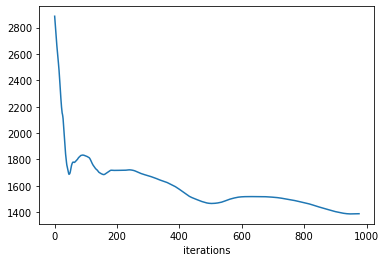

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.xlabel('iterations')
plt.ylabel('')
plt.show()

In [ ]:
# Cracked
#cracked_single_img = next(iter(dataloader_cracked))[0].to(device)[0]
print(cracked_batch.size())
print(type(cracked_batch))

plt.axis("off")
plt.title("Cracked Image")
plt.imshow(np.transpose(vutils.make_grid(cracked_batch[0].to(device)[:batch_size], padding=1, normalize=True).cpu(),(1,2,0)))
plt.show()

# Fake
fake_batch = netG(noise)
#fake_single_img = fake_batch[0]
print(fake_batch.size())
print(type(fake_batch))

plt.axis("off")
plt.title("Fake Image")
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device)[:batch_size], padding=1, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
!pip install tflib

  Created wheel for tflib: filename=tflib-0.1.0-py3-none-any.whl size=1854 sha256=00684e01c22a518713f7c0bd2e99a59bd5950b7649ee97d35c261e04b1f32c99
  Stored in directory: /root/.cache/pip/wheels/1c/ef/c8/00fe7b9b4c4df73c5b26d43ef6e4f35045bb23cffdd7aabc70
Successfully built tflib


In [ ]:
"""
Training of the WGAN-GP model
Copyright (c) 2017 Ishaan Gulrajani
Copyright (c) 2018 Thomas Schlegl ... modified and extended
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""


import os, sys
import numpy as np
import re
sys.path.append(os.getcwd())

import tensorflow as tf
import time
import functools
from tqdm import tqdm

import tflib as lib
import tflib.ops.linear
import tflib.ops.conv2d
import tflib.ops.batchnorm
import tflib.ops.deconv2d
import tflib.save_images
import tflib.img_loader
import tflib.ops.layernorm
import tflib.plot


class bcolors:
    PINK = '\033[95m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    ENDC = '\033[0m'

timestamp = time.strftime("%Y-%m-%d-%H%M")
filename = os.path.basename(__file__).strip('.py')


MODE = 'wgan-gp'
RAND_SAMPLING = 'normal' # 'unif'
DIM = 64 # Model dimensionality
CRITIC_ITERS = 5
N_GPUS = 1
BATCH_SIZE = 64
LAMBDA = 10 # Gradient penalty hyperpar
OUTPUT_DIM = 64*64*1 # Number of pixels in each image
ZDIM = 128
TRAIN_EPOCHS = 7
ZSPACE_SMPL_NRIMG = 5
ZSPACE_SMPL_PTS = 13
checkpoint_iter = None


run_name = "%s_%s_crIt%d_%s" %(filename, RAND_SAMPLING, CRITIC_ITERS, timestamp)
checkpoint_dir = os.path.join("wganTrain", run_name, "checkpoints")
log_dir    = os.path.join("wganTrain", run_name, "logs")
samples_dir  = os.path.join("wganTrain", run_name, "samples")
z_interp_dir = os.path.join("wganTrain", run_name, "z_interp")


print bcolors.GREEN + "\n=== WGAN-GP TRAINING PARAMETERS ===" + bcolors.ENDC
lib.print_model_settings(locals().copy())

DEVICES = ['/gpu:{}'.format(i) for i in xrange(N_GPUS)]


def Normalize(name, axes, inputs):
    if ('Discriminator' in name) and (MODE == 'wgan-gp'):
        if axes != [0,2,3]:
            raise Exception('Layernorm over non-standard axes is unsupported')
        return lib.ops.layernorm.Layernorm(name,[1,2,3],inputs)
    else:
        return lib.ops.batchnorm.Batchnorm(name,axes,inputs,fused=True)

def my_Normalize(name, inputs, is_training):
    if ('Discriminator' in name) and (MODE == 'wgan-gp'):
        return lib.ops.layernorm.Layernorm(name,[1,2,3],inputs)
    else:
        return tf.layers.batch_normalization(inputs, axis=1, training=is_training, name=name)

def ConvMeanPool(name, input_dim, output_dim, filter_size, inputs, he_init=True, biases=True):
    output = lib.ops.conv2d.Conv2D(name, input_dim, output_dim, filter_size, inputs, he_init=he_init, biases=biases)
    output = tf.add_n([output[:,:,::2,::2], output[:,:,1::2,::2], output[:,:,::2,1::2], output[:,:,1::2,1::2]]) / 4.
    return output

def MeanPoolConv(name, input_dim, output_dim, filter_size, inputs, he_init=True, biases=True):
    output = inputs
    output = tf.add_n([output[:,:,::2,::2], output[:,:,1::2,::2], output[:,:,::2,1::2], output[:,:,1::2,1::2]]) / 4.
    output = lib.ops.conv2d.Conv2D(name, input_dim, output_dim, filter_size, output, he_init=he_init, biases=biases)
    return output

def UpsampleConv(name, input_dim, output_dim, filter_size, inputs, he_init=True, biases=True):
    output = inputs
    output = tf.concat([output, output, output, output], 1)
    output = tf.transpose(output, [0,2,3,1])
    output = tf.depth_to_space(output, 2)
    output = tf.transpose(output, [0,3,1,2])
    output = lib.ops.conv2d.Conv2D(name, input_dim, output_dim, filter_size, output, he_init=he_init, biases=biases)
    return output

def ResidualBlock(name, input_dim, output_dim, filter_size, inputs, is_training=True, resample=None, he_init=True):
    """
    resample: None, 'down', or 'up'
    """
    if resample=='down':
        conv_shortcut = MeanPoolConv
        conv_1        = functools.partial(lib.ops.conv2d.Conv2D, input_dim=input_dim, output_dim=input_dim)
        conv_2        = functools.partial(ConvMeanPool, input_dim=input_dim, output_dim=output_dim)
    elif resample=='up':
        conv_shortcut = UpsampleConv
        conv_1        = functools.partial(UpsampleConv, input_dim=input_dim, output_dim=output_dim)
        conv_2        = functools.partial(lib.ops.conv2d.Conv2D, input_dim=output_dim, output_dim=output_dim)
    elif resample==None:
        conv_shortcut = lib.ops.conv2d.Conv2D
        conv_1        = functools.partial(lib.ops.conv2d.Conv2D, input_dim=input_dim,  output_dim=input_dim)
        conv_2        = functools.partial(lib.ops.conv2d.Conv2D, input_dim=input_dim, output_dim=output_dim)
    else:
        raise Exception('invalid resample value')

    if output_dim==input_dim and resample==None:
        shortcut = inputs # Identity skip-connection
    else:
        shortcut = conv_shortcut(name+'.Shortcut', input_dim=input_dim, output_dim=output_dim, filter_size=1,
                                 he_init=False, biases=True, inputs=inputs)

    output = inputs
    if is_training is not None:
        output = my_Normalize(name+'.BN1', output, is_training)
    else:
        output = Normalize(name+'.BN1', [0,2,3], output)
    output = tf.nn.relu(output)
    output = conv_1(name+'.Conv1', filter_size=filter_size, inputs=output, he_init=he_init, biases=False)
    if is_training is not None:
        output = my_Normalize(name+'.BN2', output, is_training)
    else:
        output = Normalize(name+'.BN2', [0,2,3], output)
    output = tf.nn.relu(output)
    output = conv_2(name+'.Conv2', filter_size=filter_size, inputs=output, he_init=he_init)

    return shortcut + output


def GoodGenerator(n_samples, noise=None, rand_sampling=RAND_SAMPLING, dim=DIM, nonlinearity=tf.nn.relu, z_out=False, is_training=True, reuse=None):
    with tf.variable_scope('Generator', reuse=reuse):
        if noise is None:
            if rand_sampling == 'unif':
                noise = tf.random_uniform([n_samples, ZDIM], minval=-1., maxval=1.)
            elif rand_sampling == 'normal':
                noise = tf.random_normal([n_samples, ZDIM])

        output = lib.ops.linear.Linear('Generator.Input', ZDIM, 4*4*8*dim, noise)
        output = tf.reshape(output, [-1, 8*dim, 4, 4])

        output = ResidualBlock('Generator.Res1', 8*dim, 8*dim, 3, output, is_training=is_training, resample='up')
        output = ResidualBlock('Generator.Res2', 8*dim, 4*dim, 3, output, is_training=is_training, resample='up')
        output = ResidualBlock('Generator.Res3', 4*dim, 2*dim, 3, output, is_training=is_training, resample='up')
        output = ResidualBlock('Generator.Res4', 2*dim, 1*dim, 3, output, is_training=is_training, resample='up')

        if is_training is not None:
            output = my_Normalize('Generator.OutputN', output, is_training)
        else:
            output = Normalize('Generator.OutputN', [0,2,3], output)
        output = tf.nn.relu(output)
        output = lib.ops.conv2d.Conv2D('Generator.Output', 1*dim, 1, 3, output)
        output = tf.tanh(output)

    if z_out:
        return tf.reshape(output, [-1, OUTPUT_DIM]), noise
    else:
        return tf.reshape(output, [-1, OUTPUT_DIM])


def GoodDiscriminator(inputs, dim=DIM, is_training=False, reuse=None, out_feats=True):
    with tf.variable_scope('Discriminator', reuse=reuse):
        output = tf.reshape(inputs, [-1, 1, 64, 64])
        output = lib.ops.conv2d.Conv2D('Discriminator.Input', 1, dim, 3, output, he_init=False)

        output = ResidualBlock('Discriminator.Res1', dim, 2*dim, 3, output, is_training=is_training, resample='down')
        output = ResidualBlock('Discriminator.Res2', 2*dim, 4*dim, 3, output, is_training=is_training, resample='down')
        output = ResidualBlock('Discriminator.Res3', 4*dim, 8*dim, 3, output, is_training=is_training, resample='down')
        output = ResidualBlock('Discriminator.Res4', 8*dim, 8*dim, 3, output, is_training=is_training, resample='down')

        output = tf.reshape(output, [-1, 4*4*8*dim])
        out_features = output
        output = lib.ops.linear.Linear('Discriminator.Output', 4*4*8*dim, 1, output)

    if out_feats:
        return tf.reshape(output, [-1]), out_features
    else:
        return tf.reshape(output, [-1])


def save(session, saver, checkpoint_dir, step):
    print(" [*] Saving checkpoint (step %d) ..." %step)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    saver.save( session,
                os.path.join(checkpoint_dir, "%s.model" %MODE),
                global_step=step)


def load(session, saver, checkpoint_dir, checkpoint_iter=None):
    print(" [*] Reading checkpoints...")

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        if checkpoint_iter is not None:
            last_ckpt_epoch = re.match(r'.*.model-(\d+)', ckpt.model_checkpoint_path).group(1)
            target_ckpt_path = re.sub( last_ckpt_epoch, str(checkpoint_iter), ckpt.model_checkpoint_path)
            saver.restore(session, target_ckpt_path)
            idxx = target_ckpt_path.rfind('/')
            ckpt_name = target_ckpt_path[idxx+1:]
        else:
            saver.restore(session, ckpt.model_checkpoint_path)
            idxx = ckpt.model_checkpoint_path.rfind('/')
            ckpt_name = ckpt.model_checkpoint_path[idxx+1:]
        return True, ckpt_name
    else:
        return False, ''


def train():
    Generator, Discriminator = GoodGenerator, GoodDiscriminator

    for dir_path in [checkpoint_dir, log_dir, samples_dir, z_interp_dir]:
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)

    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
        all_real_data_conv = tf.placeholder(tf.int32, shape=[BATCH_SIZE, 1, 64, 64])
        if tf.__version__.startswith('1.'):
            split_real_data_conv = tf.split(all_real_data_conv, len(DEVICES))
            print("\n\nDEVICES: %s\n\n").format(DEVICES)
        else:
            split_real_data_conv = tf.split(0, len(DEVICES), all_real_data_conv)
        gen_costs, disc_costs = [],[]

        for device_index, (device, real_data_conv) in enumerate(zip(DEVICES, split_real_data_conv)):
            with tf.device(device):
                real_data = tf.reshape(2*((tf.cast(real_data_conv, tf.float32)/255.)-.5), [BATCH_SIZE/len(DEVICES), OUTPUT_DIM])
                fake_data = Generator(BATCH_SIZE/len(DEVICES), rand_sampling=RAND_SAMPLING, is_training=True)

                disc_real = Discriminator(real_data, out_feats=False)
                disc_fake = Discriminator(fake_data, reuse=True, out_feats=False)

                if MODE == 'wgan-gp':
                    gen_cost = -tf.reduce_mean(disc_fake)
                    disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)

                    alpha = tf.random_uniform(
                        shape=[BATCH_SIZE/len(DEVICES),1], 
                        minval=0.,
                        maxval=1.
                    )
                    differences = fake_data - real_data
                    interpolates = real_data + (alpha*differences)
                    gradients = tf.gradients(Discriminator(interpolates, reuse=True, out_feats=False), [interpolates])[0]
                    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
                    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
                    disc_cost += LAMBDA*gradient_penalty

                gen_costs.append(gen_cost)
                disc_costs.append(disc_cost)

        gen_cost = tf.add_n(gen_costs) / len(DEVICES)
        disc_cost = tf.add_n(disc_costs) / len(DEVICES)

        if MODE == 'wgan-gp':
            t_vars = tf.trainable_variables()
            gen_vars = [var for var in t_vars if 'Generator' in var.name]
            dis_vars = [var for var in t_vars if 'Discriminator' in var.name]

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            update_ops_gen = [var for var in update_ops if 'Generator' in var.name] 
            update_ops_dis = [var for var in update_ops if 'Discriminator' in var.name] 

            with tf.control_dependencies(update_ops_gen):
                gen_train_op = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0., beta2=0.9).minimize(gen_cost,
                                              var_list=gen_vars, colocate_gradients_with_ops=True)
            with tf.control_dependencies(update_ops_dis):
                disc_train_op = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0., beta2=0.9).minimize(disc_cost,
                                               var_list=dis_vars, colocate_gradients_with_ops=True)


        # For generating samples
        if RAND_SAMPLING == 'unif':
            fixed_noise = tf.constant(np.random.uniform(-1, 1, size=(BATCH_SIZE, ZDIM)).astype('float32'))
        elif RAND_SAMPLING == 'normal':
            fixed_noise = tf.constant(np.random.normal(size=(BATCH_SIZE, ZDIM)).astype('float32'))

        all_fixed_noise_samples = []
        for device_index, device in enumerate(DEVICES):
            n_samples = BATCH_SIZE / len(DEVICES)
            all_fixed_noise_samples.append(Generator(n_samples, noise=fixed_noise[device_index*n_samples:(device_index+1)*n_samples], rand_sampling=RAND_SAMPLING, is_training=False, reuse=True ) )
        if tf.__version__.startswith('1.'):
            all_fixed_noise_samples = tf.concat(all_fixed_noise_samples, 0)
        else:
            all_fixed_noise_samples = tf.concat(0, all_fixed_noise_samples)

        def generate_image(epoch, iteration):
            samples = session.run(all_fixed_noise_samples)
            samples = ((samples+1.)*(255.99/2)).astype('int32')
            lib.save_images.save_images(samples.reshape((BATCH_SIZE, 1, 64, 64)), '{}/samples_epoch{}-{}.png'.format(samples_dir, epoch, iteration))


        # Dataset iterator
        train_gen,_ = lib.img_loader.load(BATCH_SIZE, 'wgan_train')

        nr_training_samples = lib.img_loader.get_nr_training_samples(BATCH_SIZE)
        nr_iters_per_epoch = nr_training_samples//BATCH_SIZE

        def inf_train_gen():
            while True:
                for (images,) in train_gen():
                    yield images

        # Save a batch of ground-truth samples
        _x = inf_train_gen().next()
        _x_r = session.run(real_data, feed_dict={real_data_conv: _x[:BATCH_SIZE/N_GPUS]})
        _x_r = ((_x_r+1.)*(255.99/2)).astype('int32')
        lib.save_images.save_images(_x_r.reshape((BATCH_SIZE/N_GPUS, 1, 64, 64)), '{}/samples_groundtruth.png'.format(samples_dir))


        # EVALUATION: z-interpolation ******
        eval_query_noise = tf.placeholder(tf.float32, shape=[ZSPACE_SMPL_PTS, ZDIM])
        zeval_gen_imgs = Generator(ZSPACE_SMPL_PTS, noise=eval_query_noise, rand_sampling=RAND_SAMPLING, is_training=False, reuse=True )

        def get_z_interpolations(smpl_pts, z_dim=ZDIM, v_len_lim=0.5):
            z_samples = np.zeros((smpl_pts, z_dim), dtype=np.float32)

            v_max = np.ones((1,100))*2  # *2 ... => 2 = [-1..1] 
            v_len_max = np.sqrt( (v_max**2).sum() ) # vector_length of v_max
            v_len_limes = v_len_max * v_len_lim
            v_len = 0

            while v_len<v_len_limes:
                if RAND_SAMPLING == 'unif':
                    z_p1 = np.random.uniform(-1, 1, [1, z_dim]).astype(np.float32)
                    z_p2 = np.random.uniform(-1, 1, [1, z_dim]).astype(np.float32)
                elif RAND_SAMPLING == 'normal':
                    z_p1 = np.random.normal(size=(1, ZDIM)).astype('float32')
                    z_p2 = np.random.normal(size=(1, ZDIM)).astype('float32')

                v = z_p2 - z_p1
                v_len = np.sqrt( (v**2).sum() ) # vector_length of v

            steps = np.linspace(0., 1., smpl_pts)
            for i,s in enumerate(steps):
                z_samples[i, :] = z_p1 + s*v

            z_imgs = session.run(zeval_gen_imgs, feed_dict={eval_query_noise: z_samples})
            return ((z_imgs+1.)*(255.99/2)).astype('int32')


        saver = tf.train.Saver(max_to_keep=10)
        session.run(tf.global_variables_initializer())
        isLoaded, ckpt = load(session, saver, checkpoint_dir, checkpoint_iter)
        start_iter = 0

        # Train loop
        iteration = 0
        for epoch in tqdm(xrange(TRAIN_EPOCHS)):
            gen = inf_train_gen()
            while iteration < ((epoch+1)*(nr_iters_per_epoch-CRITIC_ITERS)):
                start_time = time.time()

                ## -- TRAIN generator --
                if (iteration+1) > 1:
                    _gen_cost, _ = session.run([gen_cost, gen_train_op])

                ## -- TRAIN critic --
                disc_iters = CRITIC_ITERS
                for i in xrange(disc_iters):
                    _data = gen.next()
                    iteration += 1
                    _disc_cost, _ = session.run([disc_cost, disc_train_op], feed_dict={all_real_data_conv: _data})

                ## -- LOGGING **
                lib.plot.tickit(iteration)

                if (iteration == (3*disc_iters)) or (iteration % (100*disc_iters) == 0):
                    lib.plot.plot('train disc cost', _disc_cost)
                    lib.plot.plot('train gen cost', _gen_cost)
                    lib.plot.plot('time', time.time() - start_time)

                if (iteration == (10*disc_iters)) or (iteration == (100*disc_iters)) or ( iteration % (1000*disc_iters) == 0):
                    generate_image(epoch+1, iteration)


                if (iteration < 10) or ( iteration % (100*disc_iters) == 0):
                    lib.plot.flush(log_dir)

                    total_samples_seen = iteration * BATCH_SIZE
                    if (epoch+1)==1:
                        nr_samples_within_epoch = total_samples_seen
                    else:
                        nr_samples_within_epoch = np.mod(total_samples_seen, epoch*(nr_iters_per_epoch-CRITIC_ITERS))
                    
                    print(bcolors.GREEN + "\tSaw real samples of %d full epochs and %10d additinal samples .. " \
                                            %(epoch, nr_samples_within_epoch) + \
                                            "(%.3f%% of epoch done!)" \
                                            %(float(nr_samples_within_epoch)/nr_training_samples) + bcolors.ENDC)

                if (iteration == (100*disc_iters)) or (iteration==(start_iter+(1000*disc_iters))) or (iteration % (1000*disc_iters) == 0):
                    z_imgs_out = np.zeros((ZSPACE_SMPL_PTS,64*ZSPACE_SMPL_NRIMG,64), dtype=np.int32)
                    for _zi in range(ZSPACE_SMPL_NRIMG):
                        z_space_smpls = get_z_interpolations( ZSPACE_SMPL_PTS )
                        z_imgs_out[:,_zi*64:(_zi+1)*64,:] = z_space_smpls.reshape(ZSPACE_SMPL_PTS,64,64)
                    lib.save_images.save_images_as_row( z_imgs_out, os.path.join(z_interp_dir, 'z_smpls-epoch%d-%05d.png'%(epoch+1, iteration)) )

            print(bcolors.BLUE + "\nEND OF EPOCH - SAVING CHECKPOINT\n" + bcolors.ENDC)
            save(session, saver, checkpoint_dir, epoch+1)
            generate_image(epoch+1, iteration)

        # SAVE FINAL MODEL
        save(session, saver, checkpoint_dir, epoch+1)
        print(bcolors.BLUE + "\nSAVING CHECKPOINT" + bcolors.ENDC)
        print(bcolors.BLUE + "Training done!\n" + bcolors.ENDC)


if __name__ == '__main__':
    train()